<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/ST_prediction_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

NN for predicting ST from theoretical data based on the somple model

In [4]:
!pip install lmfit
# !pip install git+https://github.com/ulikoehler/UliEngineering.git


     |████████████████████████████████| 292 kB 5.1 MB/s 
     |████████████████████████████████| 98 kB 9.0 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84401 sha256=d2a88d89718c4f031ace858e8cba7423dd18eaf0ad1956a76939bb189e1d39bb
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
  Created wheel for asteval: filename=asteval-0.9.25-py3-none-any.whl size=17301 sha256=50b160b38972e6348f15ada104efd6d172d7bd091537f7ff6dd61f5bcd9c957f
  Stored in directory: /root/.cache/pip/wheels/4a/87/53/f1385a55b3f60eabb921c5f4fd151c00fdb016b5111b8c830f
Successfully built lmfit asteval


In [5]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  #!!! Why though? !!!

import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import io

# from UliEngineering.Math.Coordinates import BoundingBox

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol, cal):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """

    a=np.arctan2(x, y)
    return a


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

Instructions for updating:
non-resource variables are not supported in the long term
2.7.0
Num GPUs Available:  0


Run the next code box only if google drive is not mounted to colab

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [ ]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
import numpy as np
file1=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_20.00_Ps_2882.0.csv'), sep="\t")
file2=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_22.00_Ps_2882.0.csv'), sep="\t")
file3=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_25.00_Ps_2882.0.csv'), sep="\t")
file4=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_27.00_Ps_2882.0.csv'), sep="\t")
file5=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_30.00_Ps_2882.0.csv'), sep="\t")
file6=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_32.00_Ps_2882.0.csv'), sep="\t")
file7=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_35.00_Ps_2882.0.csv'), sep="\t")
file8=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_40.00_Ps_2882.0.csv'), sep="\t")
file9=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_45.00_Ps_2882.0.csv'), sep="\t")
file10=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_50.00_Ps_2882.0.csv'), sep="\t")
file11=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_55.00_Ps_2882.0.csv'), sep="\t")
file12=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_60.00_Ps_2882.0.csv'), sep="\t")
file13=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_65.00_Ps_2882.0.csv'), sep="\t")
file14=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_70.00_Ps_2882.0.csv'), sep="\t")
file15=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/volatile_solvents/MLtheory_ST_72.00_Ps_2882.0.csv'), sep="\t")
file16=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_20.00_Rsph_0.54.csv'), sep="\t")
file17=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_22.00_Rsph_0.67.csv'), sep="\t")
file18=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_25.00_Rsph_0.59.csv'), sep="\t")
file19=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_25.00_Rsph_0.67.csv'), sep="\t")
file20=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_30.00_Rsph_0.67.csv'), sep="\t")
file21=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_35.00_Rsph_0.67.csv'), sep="\t")
file22=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_40.00_Rsph_0.80.csv'), sep="\t")
file23=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_45.00_Rsph_0.94.csv'), sep="\t")
file24=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_50.00_Rsph_1.07.csv'), sep="\t")
file25=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_55.00_Rsph_1.21.csv'), sep="\t")
file26=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_60.00_Rsph_1.34.csv'), sep="\t")
file27=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_65.00_Rsph_1.45.csv'), sep="\t")
file28=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_65.00_Rsph_1.47.csv'), sep="\t")
file29=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_70.00_Rsph_1.61.csv'), sep="\t")
file30=pd.read_csv(str('/content/drive/My Drive/DropLev/Theory_simple_model/non_volatile_solvents/MLtheory_ST_72.00_Rsph_1.61.csv'), sep="\t")

#input=np.vstack([file1, file2, file3, file4, file5, file6, file7, file8, file9, file10, file11, file12, file13, file14, file15])
#input=np.vstack([file16, file17, file18, file19, file20, file21, file22, file23, file24, file25, file26, file27, file28, file29, file30])
input=np.vstack([file1, file2, file16])
input.shape
#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)


(297, 304)

In [7]:
raw_dataset=pd.read_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/insilico_raw_dataset.csv')
raw_dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
69995,0.010855,0.108960,0.117982,0.123548,0.178754,0.208026,0.210260,0.210613,0.241214,0.257454,0.373672,0.444223,0.462844,0.463890,0.538084,0.685797,0.686468,0.701369,0.770069,0.808078,0.810788,0.981887,1.019156,1.033622,1.144772,1.162780,1.201802,1.227934,1.290173,1.295994,1.387766,1.408496,1.480327,1.487336,1.555154,1.567932,1.600199,1.603530,1.686535,1.711603,...,0.841752,0.839782,0.834071,0.829517,0.824138,0.823524,0.813916,0.808007,0.802349,0.799632,0.788503,0.779049,0.778646,0.772972,0.772031,0.754237,0.749814,0.745530,0.743522,0.743395,0.741137,0.738202,0.735540,0.733585,0.732797,0.730199,0.724222,0.721604,0.719930,0.719183,0.718706,0.718650,0.714021,0.712145,0.711642,2.256124,2431.280160,53.160022,0.823033,0.864621
69996,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
69997,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
69998,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
69999,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [8]:
dataset=pd.read_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/insilico_dataset_after_conditions.csv')
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
46681,0.030986,0.043993,0.069600,0.076387,0.105062,0.146140,0.290678,0.299159,0.391326,0.464221,0.565064,0.569203,0.666356,0.679697,0.754009,0.764006,0.764584,0.787188,0.793261,0.804187,0.823263,0.836253,0.870887,0.887160,0.893436,0.914365,0.932719,0.950392,0.961020,0.995464,1.009505,1.052084,1.059491,1.088541,1.108529,1.111417,1.162814,1.206144,1.223849,1.356779,...,0.734074,0.724307,0.712627,0.708045,0.701435,0.689868,0.685407,0.684123,0.680043,0.668149,0.653693,0.634339,0.628660,0.617359,0.613480,0.611143,0.602544,0.593223,0.589916,0.587846,0.583124,0.581537,0.580342,0.572257,0.571020,0.570747,0.570433,0.569691,0.569239,0.564626,0.557214,0.556148,0.555720,0.554701,0.554566,1.339101,2752.622531,34.276755,0.741041,0.748316
46682,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
46683,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
46684,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
46685,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [316]:
#Remove 10% of the data within a specific ST range

target=len(dataset)*0.1

ST_lim1=37
ST_lim2=30

trial=dataset.copy()

trial.drop(trial[(trial['ST'] < ST_lim1) & (trial['ST'] > ST_lim2)].index, inplace=True)
(len(dataset)-len(trial))*100/len(dataset)

10.086535578117637

In [317]:
dataset=trial.copy()
dataset.reset_index(drop=True, inplace=True)
dataset

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
0,0.041563,0.044561,0.087291,0.099319,0.106686,0.118206,0.160993,0.161439,0.169340,0.182299,0.199885,0.445477,0.510637,0.523041,0.583204,0.589587,0.632548,0.688679,0.722330,0.795754,0.831361,0.852771,0.861375,0.897562,0.913303,0.924330,0.976472,1.125626,1.153036,1.197646,1.219195,1.269700,1.276502,1.323495,1.424899,1.442418,1.516127,1.590692,1.610198,1.657989,...,0.625225,0.620845,0.616653,0.609801,0.605985,0.601920,0.594246,0.585163,0.580981,0.568197,0.564806,0.564025,0.563391,0.552289,0.546939,0.542713,0.521300,0.514483,0.513633,0.513281,0.507163,0.505045,0.503060,0.501568,0.496324,0.490216,0.487142,0.486780,0.486559,0.485761,0.485022,0.484405,0.484400,0.483928,0.483319,0.883039,3567.856909,46.746258,0.740311,0.651113
1,0.031995,0.061198,0.098526,0.135025,0.209303,0.210130,0.231797,0.262124,0.268078,0.271128,0.302164,0.319600,0.326606,0.329878,0.343679,0.465876,0.466595,0.467585,0.478167,0.479436,0.511843,0.547697,0.565258,0.566211,0.652728,0.725842,0.851034,0.880259,0.880542,0.913696,0.970254,0.977811,1.019219,1.045876,1.114887,1.164079,1.198859,1.205736,1.207401,1.288531,...,0.774463,0.771172,0.757296,0.757189,0.752230,0.752166,0.750772,0.748452,0.733388,0.731494,0.728894,0.721070,0.716686,0.713856,0.706885,0.703514,0.699213,0.695574,0.694153,0.687537,0.685450,0.684505,0.682110,0.679875,0.679844,0.677956,0.673779,0.666898,0.665969,0.665363,0.664973,0.664802,0.664731,0.664719,0.664671,1.744218,2538.652174,57.492559,0.843827,0.787671
2,0.119452,0.177902,0.184241,0.201084,0.211789,0.249744,0.262464,0.267379,0.287838,0.317084,0.330280,0.355584,0.390938,0.391906,0.396423,0.418110,0.437155,0.525031,0.528214,0.564618,0.568985,0.597888,0.603994,0.626760,0.698653,0.703106,0.742619,0.750423,0.791821,0.846977,0.874489,0.893318,0.934565,0.960422,0.969704,0.973573,0.989449,1.017955,1.023819,1.078069,...,0.752992,0.750547,0.742454,0.736880,0.735320,0.725643,0.722753,0.719467,0.703276,0.687137,0.686599,0.680459,0.675077,0.674891,0.666574,0.628772,0.626787,0.615785,0.615242,0.610471,0.598030,0.587877,0.584669,0.583201,0.582494,0.572976,0.571534,0.570559,0.569995,0.569879,0.560489,0.553077,0.552885,0.548388,0.545428,1.375455,3012.180582,37.441003,0.717424,0.759582
3,0.003006,0.066131,0.069708,0.080491,0.094323,0.128114,0.137812,0.191194,0.195439,0.204116,0.222026,0.238220,0.321583,0.329820,0.397684,0.410535,0.422817,0.427276,0.529588,0.534159,0.600119,0.615587,0.693212,0.762863,0.796286,0.807022,0.858058,0.916633,0.944410,0.961712,1.033100,1.095345,1.120011,1.168878,1.188810,1.191824,1.202724,1.239836,1.267201,1.315417,...,0.634412,0.632743,0.631483,0.622130,0.618787,0.618154,0.615200,0.614805,0.613963,0.610761,0.610629,0.609564,0.609093,0.604476,0.604433,0.603675,0.603198,0.602695,0.601962,0.601939,0.600442,0.599952,0.596831,0.596028,0.595856,0.595195,0.593203,0.593197,0.592749,0.592655,0.592559,0.592342,0.591970,0.591845,0.591837,1.045185,2250.855881,63.750254,0.912994,0.648120
4,0.044171,0.067475,0.075926,0.101222,0.155178,0.184597,0.189699,0.233883,0.260962,0.278711,0.284231,0.359199,0.396476,0.421785,0.423722,0.428259,0.443520,0.444262,0.447783,0.472103,0.588662,0.601059,0.636821,0.647850,0.688378,0.744537,0.746250,0.793889,0.809870,0.869478,0.875169,0.883555,0.920775,0.940926,0.946622,1.075105,1.093712,1.106163,1.123314,1.151334,...,0.703053,0.700255,0.700221,0.698591,0.690872,0.687013,0.68646

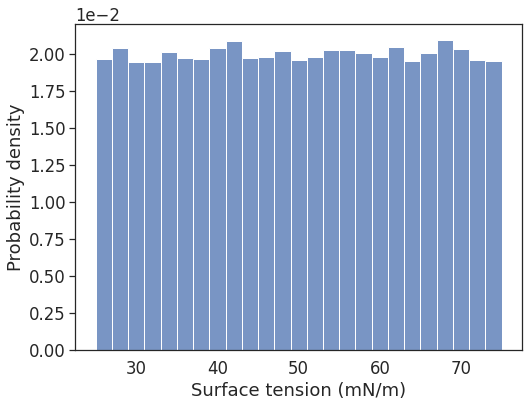

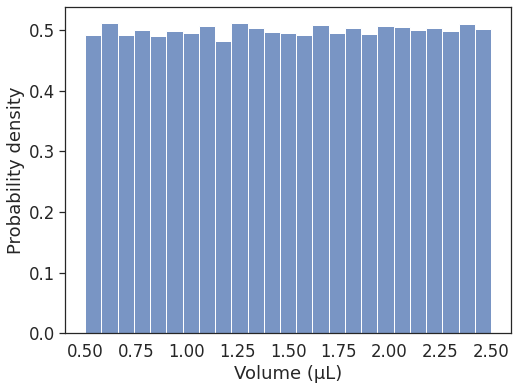

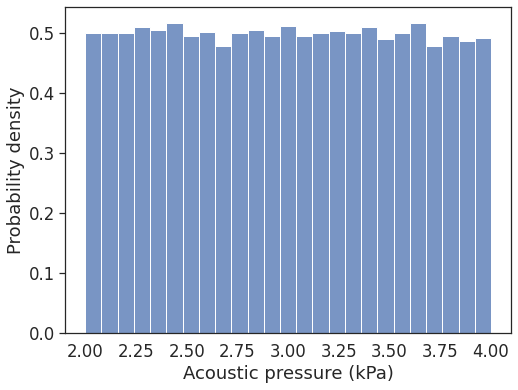

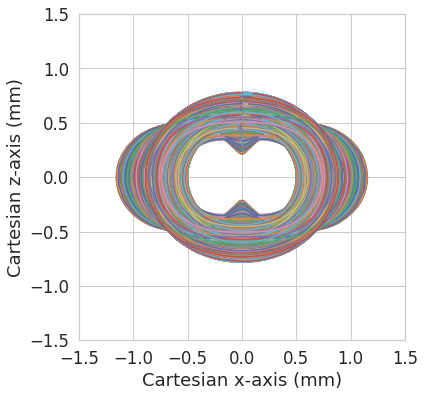

In [28]:
#Data distribution

savefig=True
figtype='png'
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/')

sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'ST_theory_before_'+figtype, dpi=300, format=figtype)

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.vol, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Volume_theory_before_'+figtype, dpi=300, format=figtype)

plt.figure(figsize=(8,6))
sns.histplot(raw_dataset.Ps/1000, kde=False, bins=25, stat="density")
plt.xlabel('Acoustic pressure (kPa)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Ps_theory_before_'+figtype, dpi=300, format=figtype)


sns.set_theme(style='whitegrid', font_scale=1.5)
sampling=175
fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
for j in range(len(raw_dataset)):
  try:
    x,y=pol2cart_theta(np.asarray(raw_dataset.iloc[j, sampling:sampling+sampling]), np.asarray(raw_dataset.iloc[j, 0:sampling]))
    plt.plot(x, y)
  except:
    j=j+1
if savefig==True:
  plt.savefig(path+'contours_theory_before_'+figtype, dpi=300, format=figtype)




**Option 3**: Generate the data

Generate random angle:
20 000 sets of 200 points

In [ ]:
def gen_data(num_sample,sampling, savefig=False):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(2.5-0.5)+0.5 # in µL
    calibration=1 #0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/343  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=343 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= np.random.random(num_sample)*(4000-2000)+2000  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    # print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*2*np.pi
    theta.sort()
    ST_range=np.random.random(num_sample)*(75-25)+25
    # print(theta.shape)
    r_all=np.empty([0,sampling])
    # print(r_all.shape)

    if type(R_sph)==float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)==float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)==float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps, Cg_air, k_o)
        r_all=np.vstack((r_all, r))
      
      if i % 1000 == 0:
        print(i)
    elif type(R_sph)!=float and type(Ps)!=float:
      for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
          #print(r)
        r_all=np.vstack((r_all, r))

    dataset=np.hstack((theta,r_all, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    if i % 1000 == 0:
      print(i)
        

    # print(r_all.shape)
    sns.set_theme(style='ticks', font_scale=1.5)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure(figsize=(8,6))
    sns.histplot(ST_range, kde=False, stat="density")
    plt.xlabel('Surface tension (mN/m)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/ST_theory_before', dpi=300, format='svg')

    if type(vol_drop) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(vol_drop, kde=False, stat="density")
      plt.xlabel('Volume (μL)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/volume_theory_before', dpi=300, format='svg')

    if type(Ps) != float:
      plt.figure(figsize=(8,6))
      sns.histplot(Ps, kde=False, stat="density")
      plt.xlabel('Acoustic pressure (Pa)')
    plt.ylabel('Probability density')
    plt.tick_params(bottom = False)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/Ps_theory_before', dpi=300, format='svg')

    sns.set_theme(style='whitegrid', font_scale=1.5)

    fig3 = plt.figure(figsize=(8,6))
    plt.xlabel('Cartesian y-axis (mm)')
    plt.ylabel('Cartesian z-axis (mm)')
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])

    for j in dataset:
      x,y=pol2cart_theta(j[sampling:sampling+sampling], j[0:sampling])
    #  print(x.shape)
    #  print(y.shape)
      plt.plot(x,y)
    if savefig== True:
      plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/contours_theory_before', dpi=300, format='svg')
    plt.show()


    return dataset

num_sample=70000  # number of different ST values
sampling=175 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('theta')
for i in range(sampling):
  column_names.append('rho')
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

raw_dataset.to_csv('./dataset.csv',index=False)


In [ ]:
# dataset = raw_dataset.copy()

# dataset.tail()


In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.5)

AR=[]
width=[]
# plt.figure()
for j in range(num_sample):
  x,y=pol2cart_theta(np.asarray(raw_dataset.iloc[j, sampling:sampling+sampling]), np.asarray(raw_dataset.iloc[j, 0:sampling]))
  # plt.plot(x, y)
  # plt.plot(max(x), 0, 'ko')
  # plt.plot(min(x), 0, 'ko')
  # plt.plot(max(y), 'ko')
  # plt.plot(min(y), 'ko')
    # print(x)
  AR.append(abs(max(y)-min(y))/abs(max(x)-min(x)))
  width.append(max(x)-min(x))

AR=np.asarray(AR)
width=np.asarray(width)
raw_dataset['AR']=AR

Conditions

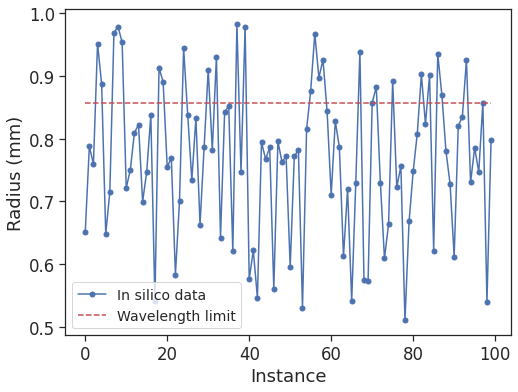

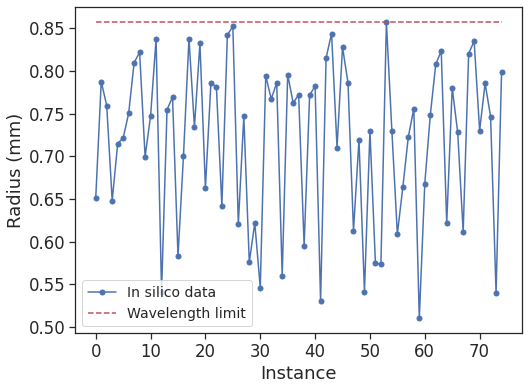

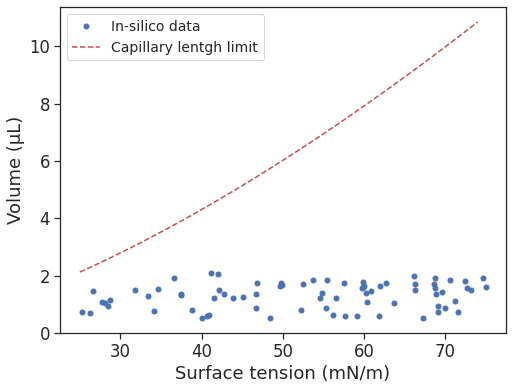

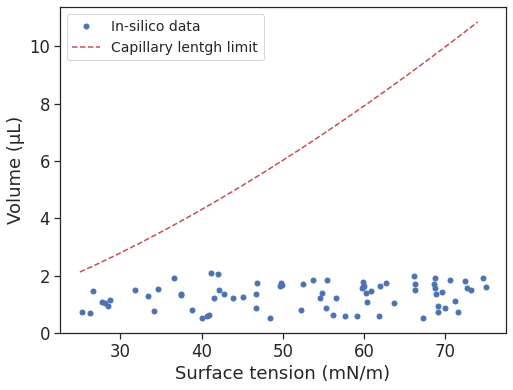

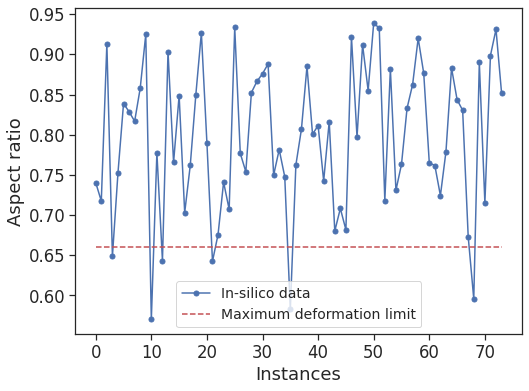

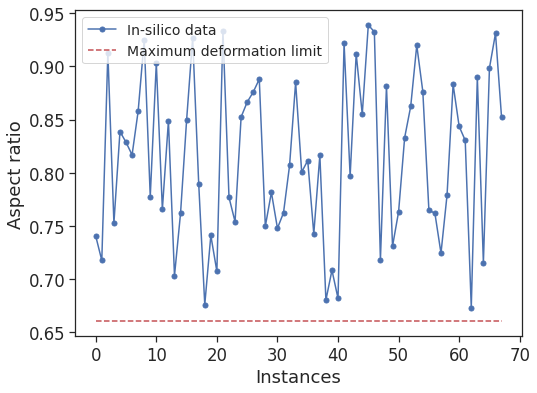

In [10]:
# radius < 1/10 of operating wavelegth 40 kHz
!mkdir -p '/content/drive/My Drive/DropLev/Dataset/' #Ceates a folder named "MachineLearningModels"


wavelength_lim = 343 / 40 # [mm] 
# radius=width/2

# raw_dataset['radius']=radius
savefig=True
figtype='svg'

sns.set_theme(style='ticks', font_scale=1.5)

path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/restrictions/')

plt.figure(figsize=(8,6))
plt.plot(raw_dataset.radius[0:100], '-ob', markersize=5, label='In silico data')
plt.plot(range(len(raw_dataset.iloc[0:100, :])), np.repeat(wavelength_lim*0.1, len(raw_dataset.iloc[0:100, :])), '--r', label='Wavelength limit')
plt.xlabel('Instance')
plt.ylabel('Radius (mm)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path + 'wavelenght_before_'+figtype, dpi=300, format=figtype)

pre_rslt_dataset= raw_dataset[0:100][raw_dataset['radius'][0:100] < wavelength_lim*0.1]
pre_rslt_dataset.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,6))
plt.plot(pre_rslt_dataset.radius, '-ob', markersize=5, label='In silico data')
plt.plot(range(len(pre_rslt_dataset)), np.repeat(wavelength_lim*0.1, len(pre_rslt_dataset)), '--r', label='Wavelength limit')
plt.xlabel('Instance')
plt.ylabel('Radius (mm)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'wavelenght_after_'+figtype, dpi=300, format=figtype)

# Capillary length check
ST_c=np.linspace(25, 74, len(pre_rslt_dataset))
lambda_c=np.sqrt(ST_c/9.81)
volume_c=(4/3)*np.pi*(lambda_c/2)**3

rslt_dataset= pre_rslt_dataset[pre_rslt_dataset['vol'] <= volume_c*0.7]
rslt_dataset.reset_index(drop=True, inplace=True)


plt.figure(figsize=(8,6))
plt.plot(pre_rslt_dataset.ST, pre_rslt_dataset.vol, 'ob', markersize=5, label='In-silico data')
plt.plot(ST_c, volume_c, '--r', label='Capillary lentgh limit')
plt.xlabel('Surface tension (mN/m)', fontsize=18)
plt.ylabel('Volume (μL)')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'capillary_length_before_cond_0.70_'+figtype, dpi=300, format=figtype)

plt.figure(figsize=(8,6))
plt.plot(rslt_dataset.ST, rslt_dataset.vol, 'ob', markersize=5, label='In-silico data')
plt.plot(ST_c, volume_c, '--r', label='Capillary lentgh limit')
plt.xlabel('Surface tension (mN/m)', fontsize=18)
plt.ylabel('Volume (μL)', fontsize=18)
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'capillary_length_after_cond_0.70_'+figtype, dpi=300, format=figtype)

#Aspect ratio
Ar_limit=0.66

final_dataset= rslt_dataset[rslt_dataset['AR'] > Ar_limit]
final_dataset.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,6))  
plt.plot(rslt_dataset.AR, '-ob', markersize=5, label='In-silico data')
plt.plot(range(len(rslt_dataset)), np.repeat(Ar_limit, len(rslt_dataset)), '--r', label='Maximum deformation limit')
plt.xlabel('Instances',fontsize=18)
plt.ylabel('Aspect ratio', fontsize=18)
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'AR_before_0.66_cond_'+figtype, dpi=300, format=figtype)


plt.figure(figsize=(8,6))  
plt.plot(final_dataset.AR, '-ob', markersize=5, label='In-silico data')
plt.plot(range(len(final_dataset)), np.repeat(Ar_limit, len(final_dataset)), '--r', label='Maximum deformation limit')
plt.xlabel('Instances')
plt.ylabel('Aspect ratio')
plt.legend(fontsize=14)
if savefig==True:
  plt.savefig(path+ 'AR_after_0.66_cond_'+figtype, dpi=300, format=figtype)


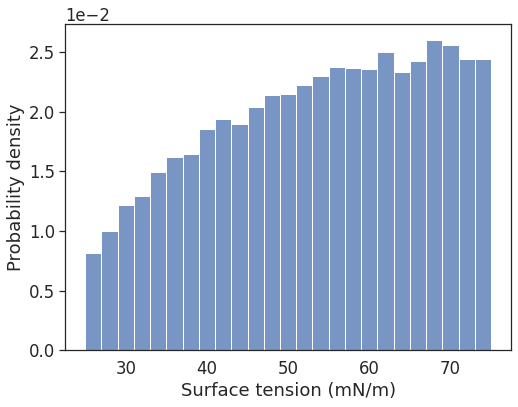

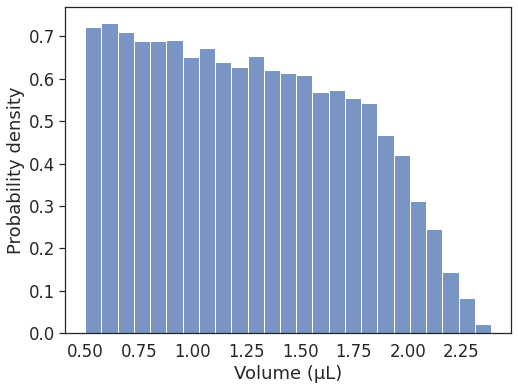

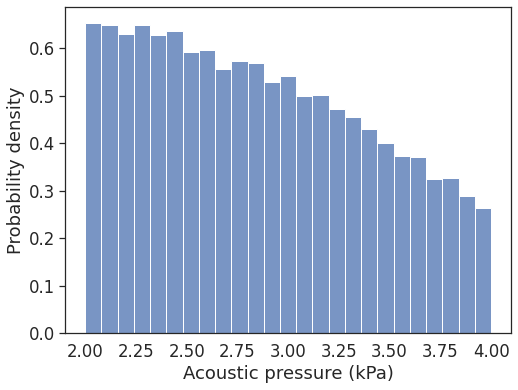

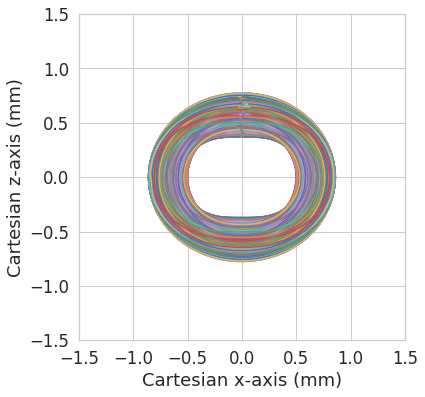

In [26]:
#New data distribution

savefig=True
figtype='png'
path=str('/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/')

sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(dataset.ST, kde=False, bins=25, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
if savefig==True:
  plt.savefig(path+'ST_theory_after_'+figtype, dpi=300, format=figtype)

plt.figure(figsize=(8,6))
sns.histplot(dataset.vol, kde=False, bins=25, stat="density")
plt.xlabel('Volume (μL)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Volume_theory_after_'+figtype, dpi=300, format=figtype)

plt.figure(figsize=(8,6))
sns.histplot(dataset.Ps/1000, kde=False, bins=25, stat="density")
plt.xlabel('Acoustic pressure (kPa)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'Ps_theory_after_'+figtype, dpi=300, format=figtype)


sns.set_theme(style='whitegrid', font_scale=1.5)
sampling=175
fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
for j in range(len(dataset)):
  try:
    x,y=pol2cart_theta(np.asarray(dataset.iloc[j, sampling:sampling+sampling]), np.asarray(dataset.iloc[j, 0:sampling]))
    plt.plot(x, y)
  except:
    j=j+1
if savefig==True:
  plt.savefig(path+'contours_theory_after_'+figtype, dpi=300, format=figtype)


# final_dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/insilico_dataset_after_conditions.csv',index=False)
# raw_dataset.to_csv('/content/drive/My Drive/DropLev/Dataset/insilico_raw_dataset.csv',index=False)




In [ ]:
# fig, ax = plt.subplots()
# plt.xlabel('Cartesian y-axis (mm)')
# plt.ylabel('Cartesian z-axis (mm)')
# ax = plt.gca()
# ax.set_aspect(1)
# ax.set_xlim([-1.5,1.5])
# ax.set_ylim([-1.5,1.5])
# for j in range(len(dataset)):
#   try:
#     x,y=pol2cart_theta(np.asarray(final_dataset.iloc[j, sampling:sampling+sampling]), np.asarray(final_dataset.iloc[j, 0:sampling]))
#     plt.plot(x, y)
#   except:
#     j=j+1
# plt.savefig('contours', dpi=300, format='pdf')

In [ ]:
# dataset=rslt_dataset.copy()

# dataset=final_dataset.reset_index(drop=True)

dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
46681,0.030986,0.043993,0.069600,0.076387,0.105062,0.146140,0.290678,0.299159,0.391326,0.464221,0.565064,0.569203,0.666356,0.679697,0.754009,0.764006,0.764584,0.787188,0.793261,0.804187,0.823263,0.836253,0.870887,0.887160,0.893436,0.914365,0.932719,0.950392,0.961020,0.995464,1.009505,1.052084,1.059491,1.088541,1.108529,1.111417,1.162814,1.206144,1.223849,1.356779,...,0.734074,0.724307,0.712627,0.708045,0.701435,0.689868,0.685407,0.684123,0.680043,0.668149,0.653693,0.634339,0.628660,0.617359,0.613480,0.611143,0.602544,0.593223,0.589916,0.587846,0.583124,0.581537,0.580342,0.572257,0.571020,0.570747,0.570433,0.569691,0.569239,0.564626,0.557214,0.556148,0.555720,0.554701,0.554566,1.339101,2752.622531,34.276755,0.741041,0.748316
46682,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
46683,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
46684,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
46685,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [ ]:
#New data distribution
# plt.figure()
# sns.histplot(dataset.ST, norm_hist=True, kde=False, stat="density")
# plt.xlabel('Surface tension (mN/m)')
# plt.ylabel('Probability density')

# plt.figure()
# sns.histplot(dataset.vol, norm_hist=True, kde=False, stat="density")
# plt.xlabel('Volume (μL)')
# plt.ylabel('Probability density')

# plt.figure()
# sns.histplot(dataset.Ps, norm_hist=True, kde=False, stat="density")
# plt.xlabel('Acoustic pressure (Pa)')
# plt.ylabel('Probability density')

# fig, ax = plt.subplots()
# plt.xlabel('Cartesian y-axis (mm)')
# plt.ylabel('Cartesian z-axis (mm)')
# ax = plt.gca()
# ax.set_aspect(1)
# ax.set_xlim([-1.5,1.5])
# ax.set_ylim([-1.5,1.5])
# for j in range(len(dataset)):
#   x,y=pol2cart_theta(np.asarray(dataset.iloc[j, sampling:sampling+sampling]), np.asarray(dataset.iloc[j, 0:sampling]))
#   plt.plot(x, y)





In [ ]:
# ST_1=dataset[(dataset['ST'] <= 72) & (dataset['ST'] > 71.5) ]
# vol_1=ST_1[(ST_1['vol']<=3 ) & (ST_1['vol'] > 2)]

# ST_3=dataset[(dataset['ST'] <= 50.5) & (dataset['ST'] > 50) ]
# vol_3=ST_3[(ST_3['vol']<=3 ) & (ST_3['vol'] > 2)]

# ST_2=dataset[(dataset['ST'] <= 25.5) & (dataset['ST'] > 25) ]
# vol_2=ST_2[(ST_2['vol']<=3 ) & (ST_2['vol'] > 2)]

# plt.figure()
# plt.plot(vol_1.Ps, vol_1.AR, 'o', label='ST=71.25+-0.25')
# plt.plot(vol_3.Ps, vol_3.AR, 'o', label='ST=50.25+-0.25')
# plt.plot(vol_2.Ps, vol_2.AR, 'o', label='ST=25.25+-0.25')
# plt.xlabel('Acoustic pressure (Pa)')
# plt.ylabel('Aspect Ratio')
# plt.legend()


###Import it using pandas for **options 1 and 2**

In [ ]:
column_names=[]

for i in range(100):
  column_names.append('rho_%d' %i)
for i in range(100):
  column_names.append('phi_%d' %i)
for i in range(100):
  column_names.append('cos2theta_%d' %i)
column_names.append('(k*R_sph)^2')
column_names.append('R_sph2')
column_names.append('Ps2*Cg_air')

column_names.append('st')

#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()


#for i in range(100):
#  dataset.pop('cos2theta_%d' %i)

dataset.pop('Ps2*Cg_air')


dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,cos2theta_63,cos2theta_64,cos2theta_65,cos2theta_66,cos2theta_67,cos2theta_68,cos2theta_69,cos2theta_70,cos2theta_71,cos2theta_72,cos2theta_73,cos2theta_74,cos2theta_75,cos2theta_76,cos2theta_77,cos2theta_78,cos2theta_79,cos2theta_80,cos2theta_81,cos2theta_82,cos2theta_83,cos2theta_84,cos2theta_85,cos2theta_86,cos2theta_87,cos2theta_88,cos2theta_89,cos2theta_90,cos2theta_91,cos2theta_92,cos2theta_93,cos2theta_94,cos2theta_95,cos2theta_96,cos2theta_97,cos2theta_98,cos2theta_99,(k*R_sph)^2,R_sph2,st
292,0.594194,0.593489,0.591385,0.587916,0.583138,0.577128,0.569983,0.561817,0.552761,0.542963,0.532578,0.521775,0.510727,0.499611,0.488608,0.477893,0.467640,0.458013,0.449166,0.441244,0.434372,0.428662,0.424205,0.421073,0.419316,0.418964,0.420020,0.422469,0.426271,0.431365,0.437669,0.445081,0.453483,0.462738,0.472698,0.483204,0.494085,0.505166,0.516270,0.527218,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
293,0.595005,0.594291,0.592158,0.588641,0.583796,0.577703,0.570458,0.562178,0.552997,0.543062,0.532534,0.521580,0.510379,0.499109,0.487953,0.477090,0.466694,0.456933,0.447964,0.439931,0.432964,0.427174,0.422655,0.419480,0.417699,0.417341,0.418413,0.420896,0.424751,0.429915,0.436307,0.443822,0.452340,0.461724,0.471822,0.482474,0.493506,0.504741,0.515999,0.527099,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
294,0.595822,0.595098,0.592935,0.589370,0.584459,0.578281,0.570936,0.562543,0.553235,0.543163,0.532489,0.521385,0.510029,0.498604,0.487293,0.476280,0.465741,0.455845,0.446753,0.438609,0.431546,0.425676,0.421095,0.417876,0.416070,0.415708,0.416794,0.419311,0.423219,0.428455,0.434935,0.442554,0.451189,0.460702,0.470940,0.481738,0.492923,0.504313,0.515727,0.526980,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
295,0.596645,0.595910,0.593718,0.590104,0.585126,0.578864,0.571418,0.562909,0.553474,0.543264,0.532444,0.521188,0.509676,0.498094,0.486629,0.475465,0.464782,0.454750,0.445533,0.437278,0.430118,0.424168,0.419524,0.416261,0.414431,0.414063,0.415164,0.417716,0.421678,0.426985,0.433554,0.441277,0.450031,0.459674,0.470052,0.480998,0.492336,0.503882,0.515452,0.526859,...,0.571157,0.633237,0.693173,0.75,0.802805,0.850737,0.893027,0.928992,0.958054,0.979746,0.993719,0.999748,0.997736,0.987715,0.969846,0.944418,0.911838,0.872632,0.82743,0.77696,0.722033,0.663534,0.602403,0.539625,0.476209,0.413176,0.35154,0.292292,0.236387,0.184724,0.138133,0.097365,0.063075,0.035816,0.016026,0.004023,3.749399e-33,0.535769,0.287049,20.0
296,0.597473,0.596729,0.594507,0.590843,0.585797,0.579450,0.571903,0.563279,0.553715,0.543366,0.532399,0.520989,0.509321,0.497582,0.485961,0.474645,0.463816,0.453648,0.444306,0.435938,0.428681,0.422650,0.417943,0.414635,0.412780,0.412407,0.413523,0.416110,0.420125,0.425505,0.432163,0.439991,0.448864,0.458639,0.469158,0.480253,0.491745,0

In [ ]:
k_o=2*np.pi*20.2/340 
dataset['(k*R_sph)^2']=(dataset['(k*R_sph)^2']*k_o)**2

#Cg_air=1/103623.50  #Pa**(-1)
#dataset['Ps2*Cg_air']=dataset['Ps2*Cg_air']*Cg_air

In [ ]:
dataset.iloc[193, :]

rho_0           6.275189e-01
rho_1           6.267880e-01
rho_2           6.246516e-01
rho_3           6.211441e-01
rho_4           6.163220e-01
                    ...     
cos2theta_98    4.021315e-03
cos2theta_99    3.749399e-33
(k*R_sph)^2     4.508115e-02
R_sph2          3.235120e-01
st              2.200000e+01
Name: 193, Length: 303, dtype: float64

### Import data for **option 3**:

In [ ]:
# loading of data

raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
dataset.tail()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("ST")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
theta,37349.0,0.035693,0.035440,8.227378e-07,0.010261,0.024899,0.049475,0.361162
theta.1,37349.0,0.071492,0.050346,1.636472e-04,0.034482,0.060312,0.096513,0.574030
theta.2,37349.0,0.107479,0.061359,3.232642e-03,0.062377,0.096337,0.140493,0.579707
theta.3,37349.0,0.143245,0.070400,5.237236e-03,0.091636,0.132066,0.183310,0.656695
theta.4,37349.0,0.179107,0.078592,8.231833e-03,0.121930,0.168152,0.224451,0.722601
...,...,...,...,...,...,...,...,...
rho.174,37349.0,0.569952,0.077461,3.721992e-01,0.510596,0.568103,0.625588,0.775893
vol,37349.0,1.258075,0.469099,5.000518e-01,0.853590,1.231933,1.637928,2.384177
Ps,37349.0,2864.616156,550.167719,2.000006e+03,2389.262786,2813.704479,3299.524076,3999.975243
AR,37349.0,0.813498,0.068886,6.600379e-01,0.761873,0.819635,0.869021,0.956393


### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)
# #normed_train_data = train_dataset
# #normed_test_data = test_dataset


In [ ]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx], idx
    
# find_nearest(train_stats['std'], 0)

(0.0, 193)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

### Min-Max transformation

In [9]:
points=175

dataset.pop('radius')
dataset.pop('AR')
dataset.pop('vol')

stats = dataset.iloc[:, points*2:].describe()
# stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Ps,46686.0,2863.219909,549.481915,2000.005607,2389.178852,2812.132616,3297.529182,3999.975243
ST,46686.0,53.379727,13.463024,25.000360,42.638635,54.446833,64.957916,74.999393


In [10]:
max_rho=[]
min_rho=[]
min_theta=[]
max_theta=[]
for i in range(len(dataset)):
  max_rho.append(max(dataset.iloc[i, 0:points].values))
  min_rho.append(min(dataset.iloc[i, 0:points].values))
  max_theta.append(max(dataset.iloc[i, points:points*2].values))
  min_theta.append(min(dataset.iloc[i, points:points*2].values))

print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

8.227377601459502e-07 6.283185168994403 0.3694943611973473 0.8602088101041859


In [11]:
# Change the range of rho from 0 to 1

OldMax= max(max_rho)
OldMin=min(min_rho)

NewValues_rho={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
      NewValues_rho[i]=NewValue

In [12]:
# Change the range of theta from 0 to 1

OldMax= max(max_theta)
OldMin=min(min_theta)

NewValues_theta={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, points:points*2] - OldMin)/(OldMax-OldMin) 
      NewValues_theta[i]=NewValue

In [13]:
df_rho=pd.DataFrame.from_dict(NewValues_rho).T
df_theta=pd.DataFrame.from_dict(NewValues_theta).T

new_df=pd.concat([df_rho, df_theta], axis=1)

new_df.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.135,rho.136,rho.137,rho.138,rho.139,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174
46681,0.004931,0.007002,0.011077,0.012157,0.016721,0.023259,0.046263,0.047613,0.062281,0.073883,0.089933,0.090591,0.106054,0.108177,0.120004,0.121595,0.121687,0.125285,0.126251,0.127990,0.131026,0.133094,0.138606,0.141196,0.142195,0.145526,0.148447,0.151259,0.152951,0.158433,0.160668,0.167444,0.168623,0.173247,0.176428,0.176887,0.185067,0.191964,0.194782,0.215938,...,0.769054,0.768562,0.763498,0.751749,0.743961,0.742957,0.723054,0.699250,0.689913,0.676444,0.652873,0.643781,0.641164,0.632850,0.608613,0.579152,0.539712,0.528139,0.505111,0.497206,0.492442,0.474918,0.455924,0.449185,0.444967,0.435343,0.432110,0.429676,0.413199,0.410679,0.410123,0.409482,0.407970,0.407048,0.397649,0.382544,0.380372,0.379499,0.377422,0.377147
46682,0.006171,0.019728,0.024864,0.034714,0.035449,0.044284,0.054884,0.054941,0.063568,0.065023,0.065307,0.070098,0.085345,0.085750,0.097239,0.103348,0.104873,0.108052,0.109986,0.128216,0.131935,0.138219,0.139816,0.141326,0.144219,0.145119,0.148135,0.150124,0.160782,0.162835,0.164285,0.169654,0.180549,0.182169,0.192777,0.207242,0.212121,0.217298,0.220185,0.226147,...,0.736131,0.733581,0.725119,0.724474,0.723837,0.723295,0.720063,0.710269,0.707039,0.687476,0.682793,0.678767,0.648104,0.638545,0.629139,0.611239,0.603789,0.590170,0.575969,0.571805,0.564993,0.524133,0.502459,0.386145,0.383256,0.379204,0.374086,0.368288,0.357985,0.352215,0.333353,0.327882,0.323622,0.307559,0.304075,0.300983,0.289125,0.278717,0.274956,0.274412
46683,0.020415,0.024641,0.025562,0.029519,0.037158,0.037252,0.040682,0.041521,0.049309,0.049506,0.052279,0.053709,0.055006,0.061037,0.068964,0.071729,0.075091,0.077899,0.078218,0.082547,0.086838,0.088713,0.088895,0.090199,0.090362,0.090389,0.095922,0.104739,0.109192,0.114937,0.124480,0.125731,0.132577,0.134642,0.136447,0.140075,0.152159,0.156800,0.165096,0.176143,...,0.889422,0.889757,0.890062,0.892271,0.893335,0.897242,0.888753,0.884573,0.870036,0.858861,0.849023,0.836948,0.819064,0.808123,0.802609,0.798701,0.794838,0.771620,0.764054,0.748944,0.746979,0.743203,0.742874,0.726165,0.722406,0.711718,0.696059,0.645238,0.641835,0.638591,0.620217,0.616080,0.613477,0.607333,0.606660,0.586818,0.578063,0.568707,0.568211,0.564942
46684,0.002174,0.005787,0.008820,0.009817,0.011726,0.011766,0.012691,0.012976,0.027476,0.028640,0.034195,0.042537,0.044967,0.068733,0.070858,0.084117,0.087922,0.095071,0.097511,0.114437,0.119188,0.120948,0.127382,0.137447,0.140745,0.146883,0.148192,0.158621,0.161041,0.167290,0.175673,0.184311,0.186147,0.186885,0.189071,0.197740,0.198230,0.201636,0.201639,0.204067,...,0.469857,0.473025,0.474760,0.480748,0.482962,0.484861,0.484340,0.484336,0.481692,0.479703,0.478816,0.474731,0.460905,0.447382,0.446029,0.381025,0.375561,0.348600,0.308740,0.305856,0.304938,0.294053,0.280350,0.277861,0.248668,0.224770,0.216353,0.214345,0.213100,0.207866,0.204065,0.201904,0.196771,0.189930,0.184314,0.183365,0.180987,0.176718,0.173473,0.173061
46685,0.007417,0.009034,0.011059,0.016544,0.018242,0.023885,0.025148,0.030733,0.042986,0.047169,0.059809,0.066887,0.071911,0.073677,0.078945,0.083988,0.086611,0.094095,0.098025,0.104015,0.110382,0.120176,0.140665,0.157383,0.165577,0.166304,0.170947,0.190802,0.193383,0.193796,0.198739,0.221498,0.241771,0.242881,0.250256,0.259468,0.260084,0.260123,0.260203,0.261357,...,0.659257,0.656438,0.656182,0.652853,0

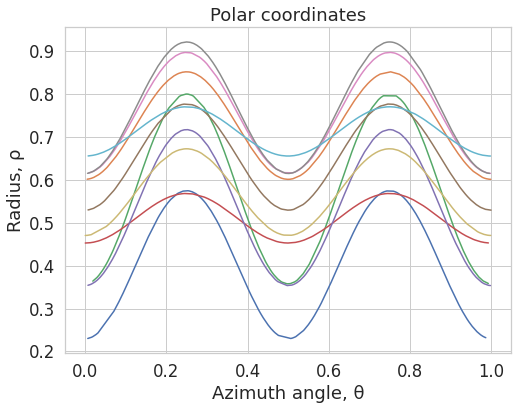

In [ ]:
sns.set_theme(style='ticks', font_scale=1.5)
plt.figure(figsize=(8,6))
plt.title('Polar coordinates')
for n in range(10):
  plt.plot(new_df.iloc[n, 0:points], new_df.iloc[n, points:points*2], '-')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')
# plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/polar_coords_after_transf', dpi=300, format='svg')

In [14]:
def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

normed_data_rest = min_max_norm(dataset.iloc[:, points*2:])


In [15]:
normed_data = new_df.copy()
# normed_data['volume'] = normed_data_rest.vol
# normed_data['centre_x'] = normed_data_rest.centre_x
# normed_data['centre_y'] = normed_data_rest.centre_y
# normed_data['Aspect_Ratio'] = normed_data_rest.Aspect_Ratio

normed_data['Ps'] = normed_data_rest.Ps
# normed_data['volt'] = normed_data_rest.volt
normed_data['ST'] = normed_data_rest.ST

normed_data.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.137,rho.138,rho.139,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,Ps,ST
46681,0.004931,0.007002,0.011077,0.012157,0.016721,0.023259,0.046263,0.047613,0.062281,0.073883,0.089933,0.090591,0.106054,0.108177,0.120004,0.121595,0.121687,0.125285,0.126251,0.127990,0.131026,0.133094,0.138606,0.141196,0.142195,0.145526,0.148447,0.151259,0.152951,0.158433,0.160668,0.167444,0.168623,0.173247,0.176428,0.176887,0.185067,0.191964,0.194782,0.215938,...,0.763498,0.751749,0.743961,0.742957,0.723054,0.699250,0.689913,0.676444,0.652873,0.643781,0.641164,0.632850,0.608613,0.579152,0.539712,0.528139,0.505111,0.497206,0.492442,0.474918,0.455924,0.449185,0.444967,0.435343,0.432110,0.429676,0.413199,0.410679,0.410123,0.409482,0.407970,0.407048,0.397649,0.382544,0.380372,0.379499,0.377422,0.377147,0.376314,0.185531
46682,0.006171,0.019728,0.024864,0.034714,0.035449,0.044284,0.054884,0.054941,0.063568,0.065023,0.065307,0.070098,0.085345,0.085750,0.097239,0.103348,0.104873,0.108052,0.109986,0.128216,0.131935,0.138219,0.139816,0.141326,0.144219,0.145119,0.148135,0.150124,0.160782,0.162835,0.164285,0.169654,0.180549,0.182169,0.192777,0.207242,0.212121,0.217298,0.220185,0.226147,...,0.725119,0.724474,0.723837,0.723295,0.720063,0.710269,0.707039,0.687476,0.682793,0.678767,0.648104,0.638545,0.629139,0.611239,0.603789,0.590170,0.575969,0.571805,0.564993,0.524133,0.502459,0.386145,0.383256,0.379204,0.374086,0.368288,0.357985,0.352215,0.333353,0.327882,0.323622,0.307559,0.304075,0.300983,0.289125,0.278717,0.274956,0.274412,0.363993,0.008295
46683,0.020415,0.024641,0.025562,0.029519,0.037158,0.037252,0.040682,0.041521,0.049309,0.049506,0.052279,0.053709,0.055006,0.061037,0.068964,0.071729,0.075091,0.077899,0.078218,0.082547,0.086838,0.088713,0.088895,0.090199,0.090362,0.090389,0.095922,0.104739,0.109192,0.114937,0.124480,0.125731,0.132577,0.134642,0.136447,0.140075,0.152159,0.156800,0.165096,0.176143,...,0.890062,0.892271,0.893335,0.897242,0.888753,0.884573,0.870036,0.858861,0.849023,0.836948,0.819064,0.808123,0.802609,0.798701,0.794838,0.771620,0.764054,0.748944,0.746979,0.743203,0.742874,0.726165,0.722406,0.711718,0.696059,0.645238,0.641835,0.638591,0.620217,0.616080,0.613477,0.607333,0.606660,0.586818,0.578063,0.568707,0.568211,0.564942,0.298590,0.433187
46684,0.002174,0.005787,0.008820,0.009817,0.011726,0.011766,0.012691,0.012976,0.027476,0.028640,0.034195,0.042537,0.044967,0.068733,0.070858,0.084117,0.087922,0.095071,0.097511,0.114437,0.119188,0.120948,0.127382,0.137447,0.140745,0.146883,0.148192,0.158621,0.161041,0.167290,0.175673,0.184311,0.186147,0.186885,0.189071,0.197740,0.198230,0.201636,0.201639,0.204067,...,0.474760,0.480748,0.482962,0.484861,0.484340,0.484336,0.481692,0.479703,0.478816,0.474731,0.460905,0.447382,0.446029,0.381025,0.375561,0.348600,0.308740,0.305856,0.304938,0.294053,0.280350,0.277861,0.248668,0.224770,0.216353,0.214345,0.213100,0.207866,0.204065,0.201904,0.196771,0.189930,0.184314,0.183365,0.180987,0.176718,0.173473,0.173061,0.623266,0.223880
46685,0.007417,0.009034,0.011059,0.016544,0.018242,0.023885,0.025148,0.030733,0.042986,0.047169,0.059809,0.066887,0.071911,0.073677,0.078945,0.083988,0.086611,0.094095,0.098025,0.104015,0.110382,0.120176,0.140665,0.157383,0.165577,0.166304,0.170947,0.190802,0.193383,0.193796,0.198739,0.221498,0.241771,0.242881,0.250256,0.259468,0.260084,0.260123,0.260203,0.261357,...,0.656182,0.652853,0.646592,0.643148,0.640958,0.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [16]:
normed_train_data = normed_data.sample(frac=0.8,random_state=0)
normed_test_data = normed_data.drop(normed_train_data.index)


In [ ]:
# plt.figure()
# for i in range(10):
#   plt.plot(normed_train_data.iloc[i, 0:175], normed_train_data.iloc[i, 175:350], 'o', markersize=1)
# plt.ylabel('Radius, ρ')
# plt.xlabel('Azimuth angle, θ')

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [17]:
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [54]:
def build_model():
  model = keras.Sequential([
    layers.Dense(40, activation=tf.nn.swish, input_shape=[len(normed_test_data.keys())]),
    layers.Dense(25, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam() 


  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
  return model

In [75]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                14080     
                                                                 
 dense_1 (Dense)             (None, 25)                1025      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 15,241
Trainable params: 15,241
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [56]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[-0.21824959],
       [-0.21610492],
       [-0.21716829],
       [-0.21349207],
       [-0.23385505],
       [-0.18555292],
       [-0.23203158],
       [-0.24060845],
       [-0.22090895],
       [-0.2266434 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [76]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



....................................................................................................
..........................................

Visualize the model's training progress using the stats stored in the `history` object.

In [77]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
137,0.011594,0.011594,0.000250,0.015053,0.015053,0.000309,137
138,0.011580,0.011580,0.000253,0.008700,0.008700,0.000164,138
139,0.012039,0.012039,0.000269,0.013095,0.013095,0.000291,139
140,0.011101,0.011101,0.000233,0.008480,0.008480,0.000124,140
141,0.012279,0.012279,0.000296,0.013655,0.013655,0.000265,141


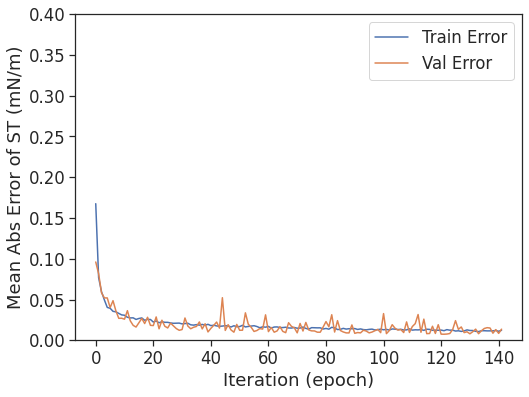

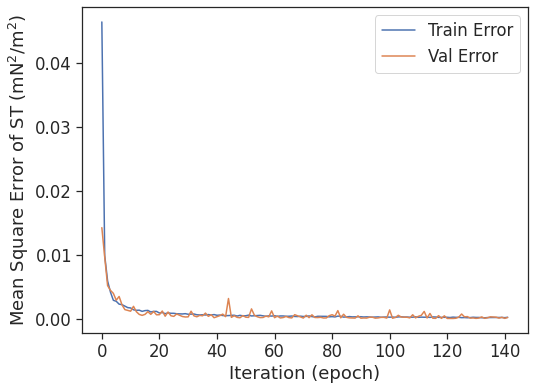

In [79]:
def plot_history(hist, savefig=False, figtype='svg', path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_'+figtype, dpi=300, format=figtype)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_'+figtype, dpi=300, format=figtype)
  plt.show()


plot_history(hist, savefig=False, figtype='svg', path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
# loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

# print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

# print("Testing set Mean Abs Error over ST range: {:5.2f}".format(mae/(max(dataset.ST)-min(dataset.ST))))


### Make predictions

Finally, predict ST values using data in the testing set:

In [80]:
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm


def density_scatter(x, y, title=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(7,7)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  plt.title(title)
  im=ax.scatter(x, y, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')
  cbar.ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0.5, 0, 'Instances')

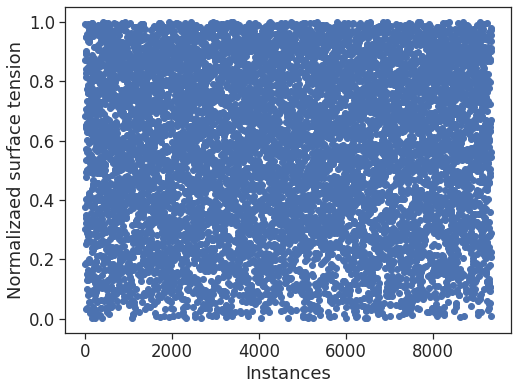

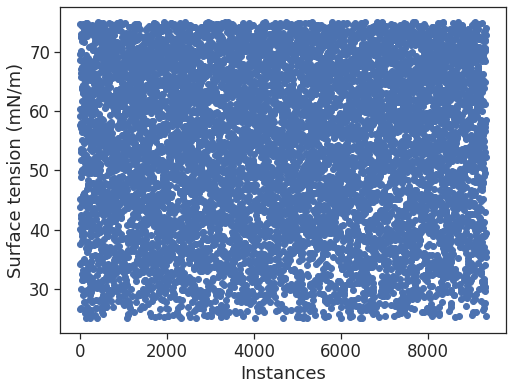

In [81]:
## De-scale target feature
def descaling_real(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

def descaling_pred(pred, true, descaled_true):
  pred=np.asarray(pred)
  true=np.asarray(true)
  de_true=np.asarray(descaled_true)
  max_true=max(de_true)
  min_true=min(de_true)
  diff=pred-true
  return diff*(max_true-min_true)+de_true

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=descaling_real(test_labels)
ST_pred_test=descaling_pred(test_predictions, test_labels, ST_real_test)

ST_real_train=descaling_real(train_labels)
ST_pred_train=descaling_pred(train_predictions, train_labels, ST_real_train)

#De-normalization check:
plt.figure(figsize=(8,6))
plt.scatter(range(len(test_labels)), test_labels)
plt.ylabel('Normalizaed surface tension')
plt.xlabel('Instances')

plt.figure(figsize=(8,6))
plt.scatter(range(len(ST_real_test)), ST_real_test)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instances')

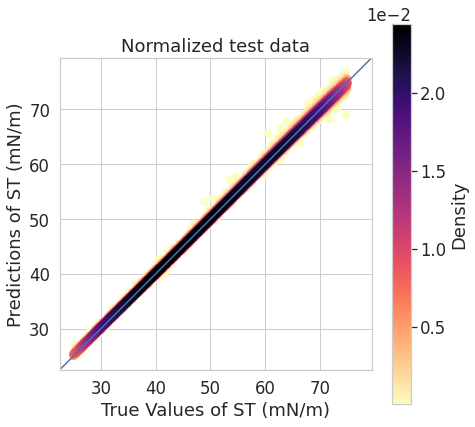

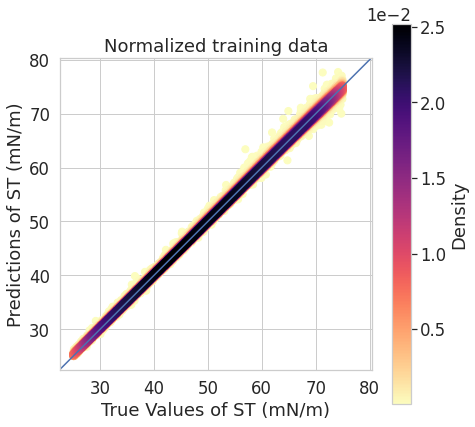

In [82]:

savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
figtype='svg'

sns.set_theme(style='whitegrid', font_scale=1.5)

density_scatter(ST_real_test, ST_pred_test, title='Normalized test data')
plt.plot([-100, 100], [-100, 100])
if savefig==True:
  plt.savefig(path+'error_plot_test_data_'+figtype, dpi=300, format=figtype)


density_scatter(ST_real_train, ST_pred_train, title='Normalized training data')
plt.plot([-100, 100], [-100, 100])
if savefig==True:
  plt.savefig(path+'error_plot_training_data_'+figtype, dpi=300, format=figtype)


Seriously?

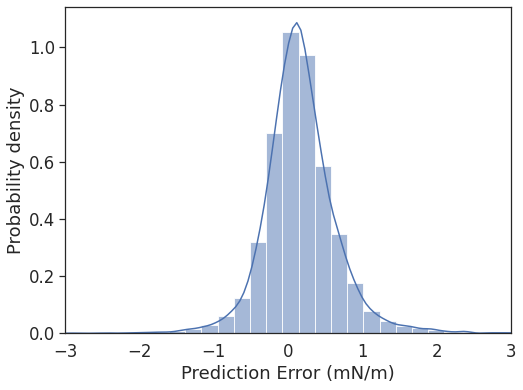

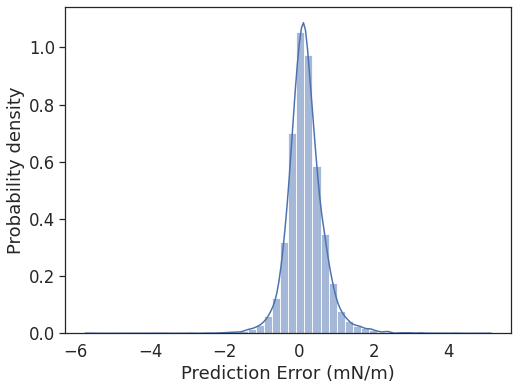

In [83]:
error_test = ST_pred_test - ST_real_test
savefig=False
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
figtype='png'

sns.set_theme(style='ticks', font_scale=1.5)
plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_lim_'+figtype, dpi=300, format=figtype)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)
# plt.xticks(np.arange(-0.1, 0.15, step=0.05), [-0.1 , -0.05,  0.  ,  0.05,  0.1])
if savefig==True:
  plt.savefig(path+'error_distrib_test_data_'+figtype, dpi=300, format=figtype)
plt.show()

In [84]:
#Confidence:

error_test_test=np.asarray(error_test)

rows_05=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]
rows_1=error_test_test[(error_test_test >= -1) & (error_test_test <= 1)]
rows_2=error_test_test[(error_test_test >= -2) & (error_test_test <= 2)]


print('Confidence for error '+u"\u00B1"+' 0.5 mN/m: %.2f' %int(len(rows_05)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 1 mN/m: %.2f' %int(len(rows_1)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 2 mN/m: %.2f' %int(len(rows_2)/len(error_test)*100)+ ' %')

print('Mean Absolute error: %.2f mN/m' %(sum(abs(error_test_test))/len(error_test_test)))


Confidence for error ± 0.5 mN/m: 75.00 %
Confidence for error ± 1 mN/m: 94.00 %
Confidence for error ± 2 mN/m: 99.00 %
Mean Absolute error: 0.37 mN/m


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

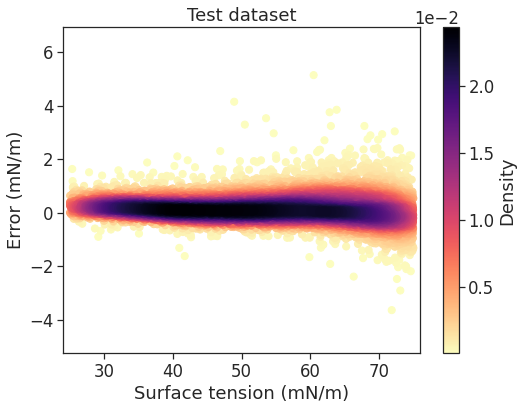

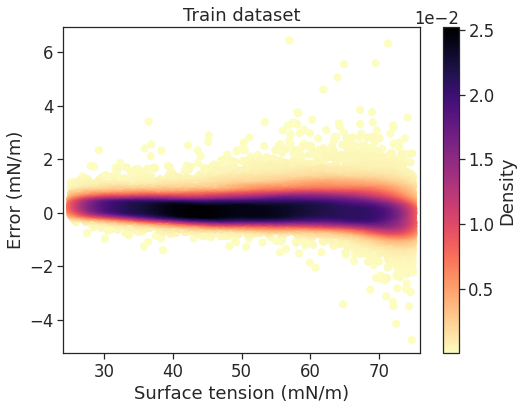

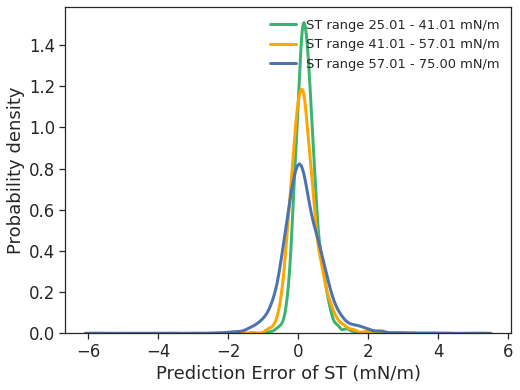

In [85]:
error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
savefig=False
figtype='svg'

density_scatter(ST_real_test, error_test, title='Test dataset',  eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.xlim(25-1, 75+1)
plt.ylabel('Error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_test_data_'+figtype, dpi=300, format=figtype)


density_scatter(ST_real_train, error_train, title='Train dataset', eq_sq=False, figsize=(8,6))
plt.ylim(min(error_train)-0.5, max(error_train)+0.5)
plt.xlim(25-1, 75+1)
plt.ylabel('Error (mN/m)')
plt.xlabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'error_Vs_ST_training_data_'+figtype, dpi=300, format=figtype)



check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

step=int((max(sorted_st.True_values)-min(sorted_st.True_values))/3)

trial_1=sorted_st.loc[(sorted_st['True_values'] >= min(sorted_st.True_values)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step))]
trial_2=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step*2))]
trial_3=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step*2)) & (sorted_st['True_values'] <= max(sorted_st.True_values))]

thickness=3

plt.figure(figsize=(8,6))
sns.distplot(trial_1.Predictions-trial_1.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='mediumseagreen', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values), min(sorted_st.True_values)+step))
sns.distplot(trial_2.Predictions-trial_2.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='orange', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step, min(sorted_st.True_values)+step*2))
sns.distplot(trial_3.Predictions-trial_3.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step*2, max(sorted_st.True_values)))
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'test_data_error_distr_steps_'+figtype, dpi=300, format=figtype)


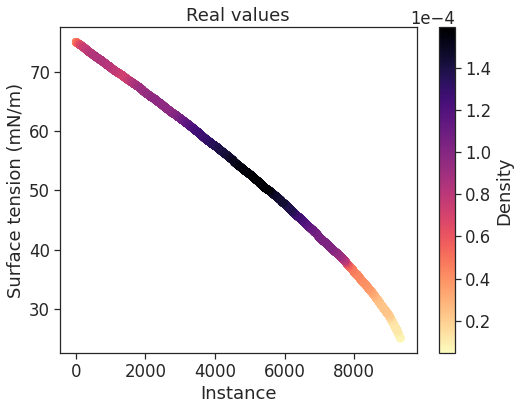

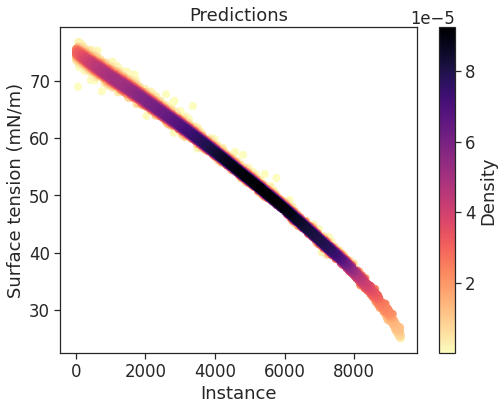

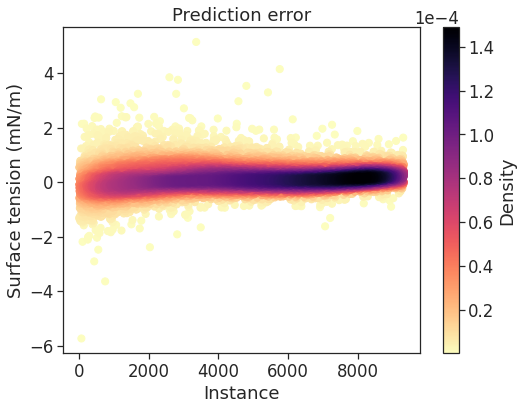

In [86]:
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
figtype='svg'
savefig=False

check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

sns.set_theme(style='ticks', font_scale=1.5)


density_scatter(range(len(sorted_st)), sorted_st.True_values,title='Real values',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_real_test_data_'+figtype, dpi=300, format=figtype)


density_scatter(range(len(sorted_st)), sorted_st.Predictions, title='Predictions',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_pred_test_data_'+figtype, dpi=300, format=figtype)

density_scatter(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values,title='Prediction error',  eq_sq=False, figsize=(8,6))
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
if savefig==True:
  plt.savefig(path+'ST_Vs_instances_pred_error_test_data_'+figtype, dpi=300, format=figtype)


In [87]:
#Save prediction outcome in a csv file
error_test = ST_pred_test - ST_real_test
error_train = ST_pred_train - ST_real_train

outcome_train=pd.DataFrame(data=np.array([ST_real_train, ST_pred_train]).T, columns=['Train_labels', 'Train_pred'])
outcome_test=pd.DataFrame(data=np.array([ST_real_test, ST_pred_test]).T, columns=[ 'Test_labels', 'Test_pred'])

date=str('20211209')

model_No=1

data_No=46685
ST_min=25
ST_max=75
vol_min=0.5
vol_max=2.5
Ps_min=2000
Ps_max=4000
error=0.37

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d__MSE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))
!mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
outcome_train.to_csv(path+'train_out_'+filename, index=False)  #Saves the file
outcome_test.to_csv(path+'test_out_'+filename, index=False)  #Saves the file

hist.to_csv(path+'history_'+filename)


## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('All_surf_five_feutures_Huber_swish_trial_3.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/"+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 50)                15150     
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 153       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 4         
Total params: 15,307
Trainable params: 15,307
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.43203562],
       [-0.3725443 ],
       [ 0.15722759],
       [-0.407181  ],
       [-0.37564555],
       [-0.37614414],
       [-0.3925074 ],
       [-0.04143935],
       [ 0.6424061 ],
       [ 0.6858951 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')

#Save the k-th epoch (100 in this case)
#class CustomSaver(keras.callbacks.Callback):
#    filepath="/content/drive/My Drive/DropLev/MachineLearningModels/"
#    def on_epoch_end(self, epoch, logs={}):
#        if epoch == 100:  # or save after some epoch, each k-th epoch etc.
#           self.model.save(str(filepath+"SDS_70mNperm_trial1.h5"), monitor = "val_loss", verbose = 0,
#  save_best_only = False, save_weights_only = False, mode = "min", period = 1)

EPOCHS = 700

#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/saved-model-{epoch:02d}-{val_loss:.2f}.h5.h5"
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, 
#                                save_weights_only=False, mode='auto', period=1)
#callbacks_list = [checkpoint]

## create and use callback:
#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/weights.100EPOCHS.h5"
#saver = CustomSaver()
#history = model.fit(normed_train_data, train_labels, callbacks=[saver], epochs=10)

#Checkpoints. Save best fit
#filepath="/content/drive/My Drive/DropLev/MachineLearningModels/weights.best.h5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
#callbacks_list = [checkpoint]

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list


....................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
15,7.163245,7.163245,130.577637,7.792389,7.792389,141.851059,15
16,7.162131,7.162131,130.552383,7.785986,7.785986,141.798523,16
17,7.154714,7.154715,130.544373,7.785559,7.785559,141.747849,17
18,7.148772,7.148772,130.395157,7.756837,7.756837,141.482620,18
19,7.155182,7.155182,130.323730,7.777982,7.777982,141.616928,19


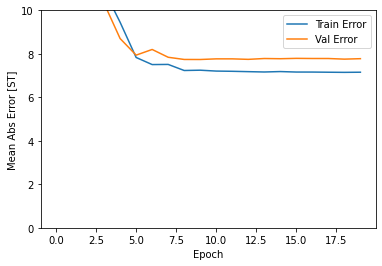

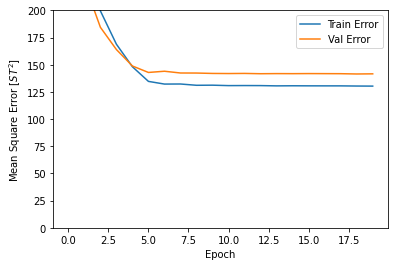

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()
  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))
# 
#keras.metrics.accuracy(normed_test_data, test_labels)

Testing set Mean Abs Error:  7.44 mN/m


### Make predictions

Finally, predict volume values using data in the testing set:

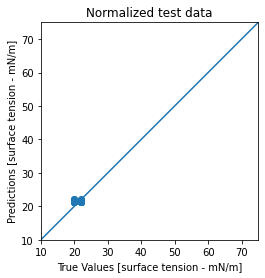

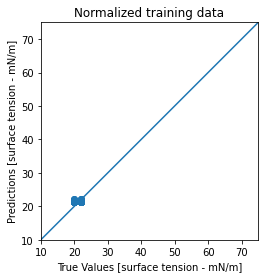

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


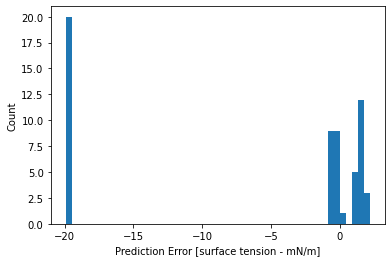

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [surface tension - mN/m]")
_ = plt.ylabel("Count")
plt.show()

## Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [64]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [65]:
import os

In [66]:
# Save the entire model as a SavedModel.
filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d__MSE_%.2f_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, error, date))
# filename='model_1_no_30_37_mN/m_20211130.csv'

!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/'+filename)  #Saves the file

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

In [ ]:
# DropLev_st_prediction_model directory
#!ls content/drive/My Drive/DropLev/MachineLearningModels

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls content/drive/My Drive/DropLev/MachineLearningModels/SDS_1.h5

Saving the model in a **HDF5** format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('content/drive/My Drive/DropLev/MachineLearningModels/'+filename) 

## Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [67]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/'+filename)

# Check its architecture
new_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                14120     
                                                                 
 dense_1 (Dense)             (None, 25)                1025      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 15,281
Trainable params: 15,281
Non-trainable params: 0
______________

For **HDF5** format

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('DropLev_st_prediction_model.h5')

# Show the model architecture
new_model.summary()

Evaluate the restored model (for both formats)

In [ ]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)

## Adding noise to the contour

In [90]:
#Import data

dataset=pd.read_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/insilico_dataset_after_conditions.csv')
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
46681,0.030986,0.043993,0.069600,0.076387,0.105062,0.146140,0.290678,0.299159,0.391326,0.464221,0.565064,0.569203,0.666356,0.679697,0.754009,0.764006,0.764584,0.787188,0.793261,0.804187,0.823263,0.836253,0.870887,0.887160,0.893436,0.914365,0.932719,0.950392,0.961020,0.995464,1.009505,1.052084,1.059491,1.088541,1.108529,1.111417,1.162814,1.206144,1.223849,1.356779,...,0.734074,0.724307,0.712627,0.708045,0.701435,0.689868,0.685407,0.684123,0.680043,0.668149,0.653693,0.634339,0.628660,0.617359,0.613480,0.611143,0.602544,0.593223,0.589916,0.587846,0.583124,0.581537,0.580342,0.572257,0.571020,0.570747,0.570433,0.569691,0.569239,0.564626,0.557214,0.556148,0.555720,0.554701,0.554566,1.339101,2752.622531,34.276755,0.741041,0.748316
46682,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
46683,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
46684,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
46685,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [91]:
import random 
pxl1=0.83/218 #mm
# percent=0.5 #50%

random_noise=pxl1*np.random.uniform(-1, 1, size=[len(dataset), 175])
scale_list=np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
noisy_rho={}

for i in range(len(scale_list)):
  noisy_rho[i]=dataset.iloc[:, 175:350]+random_noise*scale_list[i]



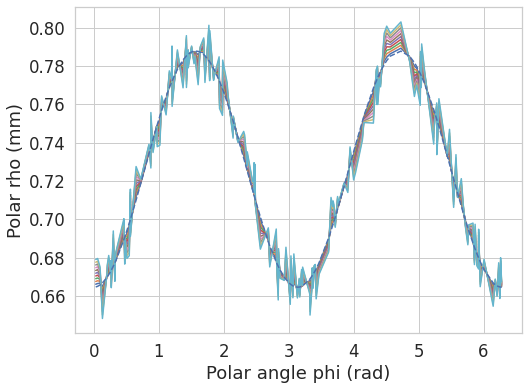

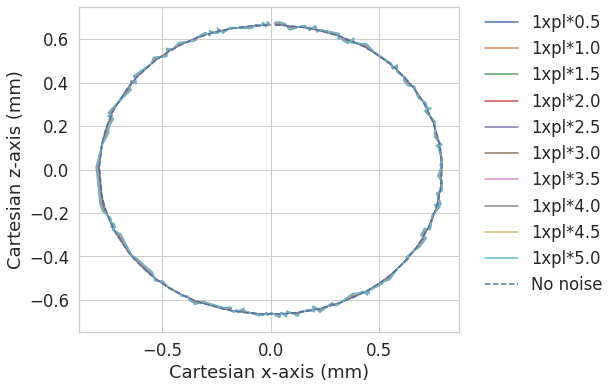

Droplet's characteristics: 1.74 μL, 2538.65 Pa, 57.49 mN/m


In [102]:
sns.set_theme(style='whitegrid', font_scale=1.5)

path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/data_distribution/'
savefig=False
figtype='png'

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  plt.plot(dataset.iloc[1, 0:175], noisy_rho[i].iloc[1, :], label='1xpl*%.1f' %scale_list[i])
plt.plot(dataset.iloc[1, 0:175], dataset.iloc[1, 175:350], '--', label='No noise')
plt.xlabel('Polar angle phi (rad)')
plt.ylabel('Polar rho (mm)')
if savefig==True:
  plt.savefig(str(path+'noisy_contours_polar_ %.2f μL_%.2f Pa_%.2f mNm_' %(dataset.iloc[1, 350], dataset.iloc[1, 351], dataset.iloc[1, 352])+figtype), dpi=300, format=figtype)
# ax1.legend(frameon=False)

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  x, y = pol2cart_theta(noisy_rho[i].iloc[1, :].values, dataset.iloc[1, 0:175].values)
  plt.plot(x, y, label='1xpl*%.1f' %scale_list[i])
x, y = pol2cart_theta(dataset.iloc[1, 175:350].values, dataset.iloc[1, 0:175].values)
plt.plot(x, y, '--', label='No noise')
plt.xlabel('Cartesian x-axis (mm)')
plt.ylabel('Cartesian z-axis (mm)')
plt.gca().set_aspect('equal', adjustable='box') 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, frameon=False)
plt.tight_layout()
plt.gcf()
if savefig==True:
  plt.savefig(str(path+'noisy_contours_Cart_ %.2f μL_%.2f Pa_%.2f mNm_' %(dataset.iloc[1, 350], dataset.iloc[1, 351], dataset.iloc[1, 352])+figtype), dpi=300, format=figtype)
plt.show()

print('''Droplet's characteristics: %.2f μL, %.2f Pa, %.2f mN/m''' %(dataset.iloc[1, 350], dataset.iloc[1, 351], dataset.iloc[1, 352]))

In [105]:
#Remove features that are not used in the training

vol=dataset.pop('vol')
AR=dataset.pop('AR')
radius=dataset.pop('radius')


In [103]:
from numpy.random import seed

sseed=50
def build_model():
  seed(sseed)
  tf.random.set_seed(sseed)
  model = keras.Sequential([
    layers.Dense(40, activation=tf.nn.swish, input_shape=[len(normed_test_data.keys())]),
   # tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True),
  #  layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(25, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.0000001)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
  optimizer = tf.keras.optimizers.Adam() #learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False
  #optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.8, beta_2=0.995)

  #model.compile(loss='mean_squared_error',
  #              optimizer=optimizer,
  #              metrics=['mean_absolute_error', 'mean_squared_error'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
  return model


class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(hist, savefig=False, figtype='svg', path='/content/drive/My Drive/DropLev/Dataset/In_Silico/'):
  sns.set_theme(style='ticks', font_scale=1.5)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MAE_'+figtype, dpi=300, format=figtype)

  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,0.05])
  plt.legend()
  if savefig==True:
    plt.savefig(path+'training_outcome_MSE_'+figtype, dpi=300, format=figtype)
  plt.show()



In [104]:
#Min-Max transformation

def MinMaxTransform(dataset, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(dataset)):
    max_rho.append(max(dataset.iloc[i, points:2*points].values))
    min_rho.append(min(dataset.iloc[i, points:2*points].values))
    max_theta.append(max(dataset.iloc[i, 0:points].values))
    min_theta.append(min(dataset.iloc[i, 0:points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = (OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_rho, df_theta], axis=1)

  return new_df


def MinMaxTransform_rho(rho, points):

  max_rho=[]
  min_rho=[]

  for i in range(len(rho)):
    max_rho.append(max(rho.iloc[i].values))
    min_rho.append(min(rho.iloc[i].values))


  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (rho.iloc[i] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T

  return df_rho

def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [129]:
## De-scale target feature
def descaling_real(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

def descaling_pred(pred, true, descaled_true):
  pred=np.asarray(pred)
  true=np.asarray(true)
  de_true=np.asarray(descaled_true)
  max_true=max(de_true)
  min_true=min(de_true)
  diff=pred-true
  return diff*(max_true-min_true)+de_true


In [106]:
noise_all_rho={}

for i in range(len(scale_list)):
  noise_all_rho[i]=pd.concat([noisy_rho[i], dataset.iloc[:, 175:350]])


In [107]:
#Normalizing data
points=175

#Normed data without noise
normed_data = MinMaxTransform(dataset, points)


#Normed data with noise
# Normed_rho_with_noise={}
Normed_data_with_noise={}

for i in range(len(scale_list)):
  Normed_rho_with_noise=MinMaxTransform_rho(noise_all_rho[i], points)
  Normed_data_with_noise[i]=pd.concat([Normed_rho_with_noise, normed_data.iloc[:, 175:350]], axis=1)


In [124]:
#Inspect the data
stats = dataset.iloc[:, points*2:].describe()
stats = stats.transpose()

#Normalizing the rest of the data
normed_data_rest = min_max_norm(dataset.iloc[:, points*2:])
# normed_data['volume'] = normed_data_rest.vol
normed_data['Ps'] = normed_data_rest.Ps
normed_data['ST'] = normed_data_rest.ST

for i in range(len(scale_list)):
  # Normed_data_with_noise[i]['volume'] = normed_data_rest.vol
  Normed_data_with_noise[i]['Ps'] = normed_data_rest.Ps
  Normed_data_with_noise[i]['ST'] = normed_data_rest.ST


In [126]:
from sklearn.utils import shuffle

normed_data_with_noise={}

np.random.seed(1234)

for i in range(len(scale_list)):
  normed_data_with_noise[i]=shuffle(Normed_data_with_noise[i], random_state=0)
  normed_data_with_noise[i].reset_index(drop=True, inplace=True)


In [130]:
# Data without noise
#Split data into train and test
normed_train_data = normed_data.sample(frac=0.8, random_state=0)
normed_test_data = normed_data.drop(normed_train_data.index)

path='/content/drive/My Drive/DropLev/for_draft/In_silico/'
date=str('20211209')

# Split features from labels
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

# The model
model = build_model()

#Training
# Display training progress by printing a single dot for each completed epoch
EPOCHS=1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=descaling_real(test_labels)
ST_pred_test=descaling_pred(test_predictions, test_labels, ST_real_test)

ST_real_train=descaling_real(train_labels)
ST_pred_train=descaling_pred(train_predictions, train_labels, ST_real_train)


error_test = ST_real_test - ST_pred_test
error_test_test=np.asarray(error_test)

mae= sum(abs(error_test_test))/len(error_test_test)
hist.to_csv(path+'history_no_noise_MAE_%.2f_' %mae +date)



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



....................................................................................................
..............

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [159]:
#Noisy data
#Split data into train and test
normed_noisy_train_data={}
normed_noisy_test_data={}
train_labels_noise={}
test_labels_noise={}


for i in range(len(scale_list)):
  np.random.seed(1234)
  normed_noisy_train_data[i] = normed_data_with_noise[i].sample(frac=0.8,random_state=0)
  normed_noisy_test_data[i] = normed_data_with_noise[i].drop(normed_noisy_train_data[i].index)
  train_labels_noise[i] = normed_noisy_train_data[i].pop('ST')
  train_labels_noise[i].reset_index(drop=True, inplace=True)
  test_labels_noise[i] = normed_noisy_test_data[i].pop('ST')
  test_labels_noise[i].reset_index(drop=True, inplace=True)

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history_noisy={}
hist_noisy={}
ST_real_test_noisy={}
ST_pred_test_noisy={}
ST_real_train_noisy={}
ST_pred_train_noisy={}
error_test_noisy={}
mae_noisy={}
model_noisy={}



path='/content/drive/My Drive/DropLev/for_draft/In_silico/'


for i in range(len(scale_list)):
  # The model
  print('Running training for model %d' %(i+1))

  model_noisy[i] = build_model()

  history_noisy[i] = model_noisy[i].fit(normed_noisy_train_data[i], train_labels_noise[i], epochs=EPOCHS,
                      validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

  hist_noisy[i] = pd.DataFrame(history_noisy[i].history)
  hist_noisy[i]['epoch'] = history_noisy[i].epoch

  # loss_noisy[i], mae_noisy[i], mse_noisy[i] = model_noisy[i].evaluate(normed_noisy_test_data[i], test_labels_noise[i], verbose=0)

  noisy_test_predictions = model_noisy[i].predict(normed_noisy_test_data[i]).flatten()
  noisy_train_predictions = model_noisy[i].predict(normed_noisy_train_data[i]).flatten()

  ST_real_test_noisy[i]=descaling_real(test_labels_noise[i])
  ST_pred_test_noisy[i]=descaling_pred(noisy_test_predictions, test_labels_noise[i], ST_real_test_noisy[i])

  ST_real_train_noisy[i]=descaling_real(train_labels_noise[i])
  ST_pred_train_noisy[i]=descaling_pred(noisy_train_predictions, train_labels_noise[i], ST_real_train_noisy[i])


  error_test_noisy[i] =ST_pred_test_noisy[i] - ST_real_test_noisy[i] 
  error_test_test_noisy=np.asarray(error_test_noisy[i])

  mae_noisy[i]= sum(abs(error_test_test_noisy))/len(error_test_test_noisy)

  hist_noisy[i].to_csv(path+'history_degree_noise_%.2f_MAE_%.2f' %(scale_list[i], mae_noisy[i]) +date)

  noisy_training_outcome_test=pd.DataFrame(data=np.array([ST_real_test_noisy[i], ST_pred_test_noisy[i]]).T, columns=[ 'Test_labels', 'Test_pred'])
  noisy_training_outcome_test.to_csv(path+'noisy_training_outcome_degree_%.2f_' %scale_list[i] + date, index=False)  #Saves the file
  noisy_training_outcome_train=pd.DataFrame(data=np.array([ST_real_train_noisy[i], ST_pred_train_noisy[i]]).T, columns=[ 'Train_labels', 'Train_pred'])
  noisy_training_outcome_train.to_csv(path+'noisy_training_outcome_degree_%.2f_' %scale_list[i] + date, index=False)  #Saves the file


Running training for model 1


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



.................................................................

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Running training for model 2

....................................................................................Running training for model 3

.................................................Running training for model 4

....................................................................................................
.................Running training for model 5

....................................................................................................
..................................Running training for model 6

....................................................................................................
................Running training for model 7

................................................................Running training for model 8

....................................................................................................Running training for model 9

...................................................................................Running tr

### Figures

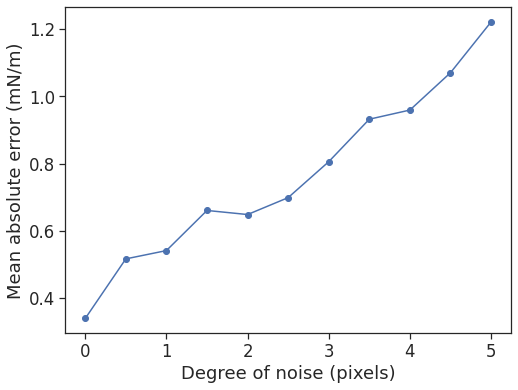

In [160]:

all_mae=np.insert(np.asarray([list(mae_noisy.items())])[0][:, 1], 0, mae)
all_degrees=np.insert(scale_list, 0, 0)

savefig=True
path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'

plt.figure(figsize=(8,6))
plt.plot(all_degrees, all_mae, '-o')
plt.xlabel('Degree of noise (pixels)')
plt.ylabel('Mean absolute error (mN/m)')
if savefig==True:
  plt.savefig(path+'MAE_Vs_degree_of_noise_svg', dpi=300, format='svg')
  plt.savefig(path+'MAE_Vs_degree_of_noise_png', dpi=300, format='png')


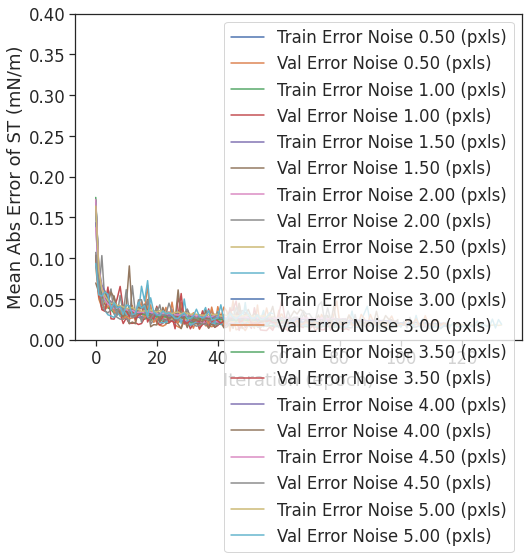

In [161]:
#Training outcome MAE Vs epochs

sns.set_theme(style='ticks', font_scale=1.5) 
savefig=True
figtype='svg'
plt.figure(figsize=(8,6))
plt.xlabel('Iteration (epoch)')
plt.ylabel('Mean Abs Error of ST (mN/m)')
plt.ylim([0,0.4])
for i in range(len(scale_list)):
  plt.plot(hist_noisy[i]['epoch'], hist_noisy[i]['mean_absolute_error'], 
           label='Train Error Noise %.2f (pxls)' %scale_list[i])
  plt.plot(hist_noisy[i]['epoch'], hist_noisy[i]['val_mean_absolute_error'],
           label = 'Val Error Noise %.2f (pxls)' %scale_list[i])
plt.legend()
if savefig==True:
  path='/content/drive/My Drive/DropLev/for_draft/In_silico/Figures/training_outcome/'
  plt.savefig(path+'MAE_Vs_epoch_noise_png'+date, dpi=300, format='png')
  plt.savefig(path+'MAE_Vs_epoch_noise_svg'+date, dpi=300, format='svg')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

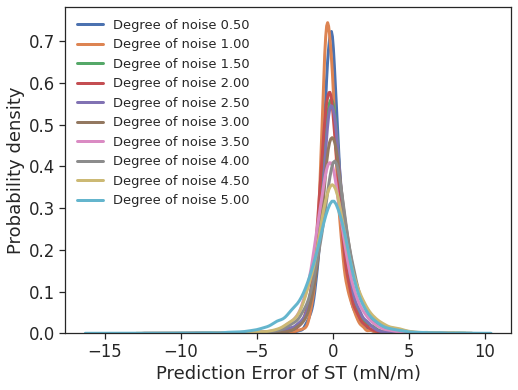

In [162]:
#Error distribution
thickness=3

plt.figure(figsize=(8,6))
for i in range(len(scale_list)):
  sns.distplot(error_test_noisy[i], hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='Degree of noise %.2f' %scale_list[i])
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
if savefig==True:
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_svg', dpi=300, format='svg')
  plt.savefig(path+'Error_distrib_Vs_ST_degree_of_noise_png', dpi=300, format='png')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


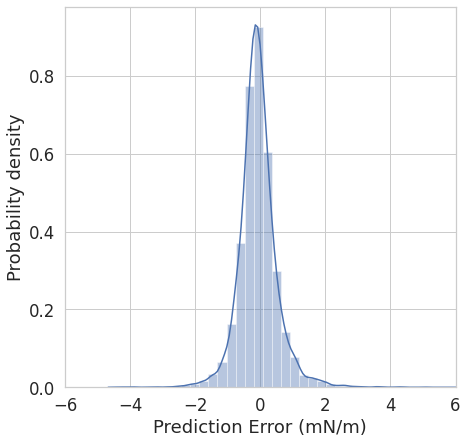

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


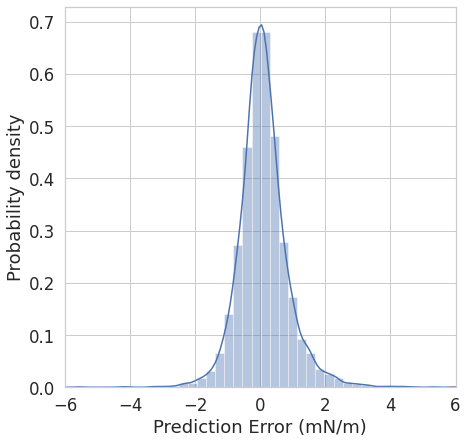

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


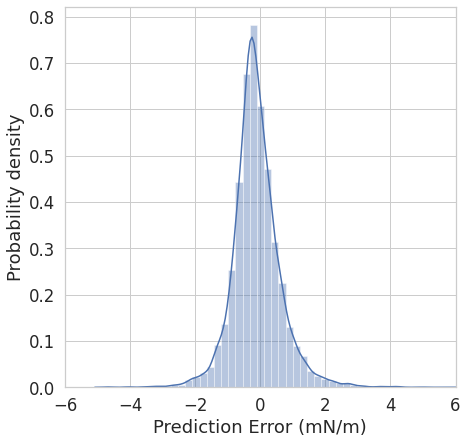

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


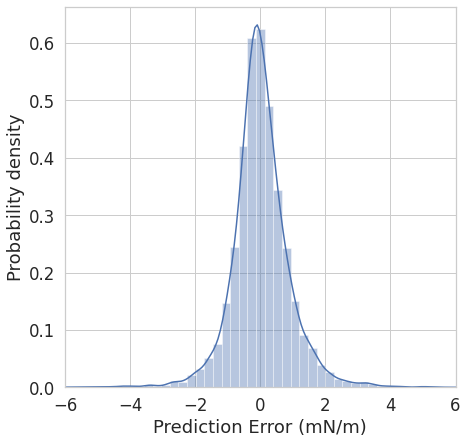

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


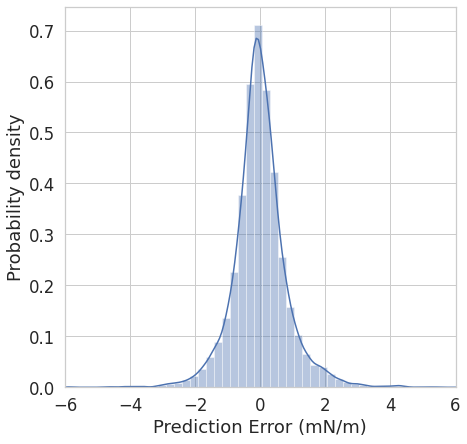

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


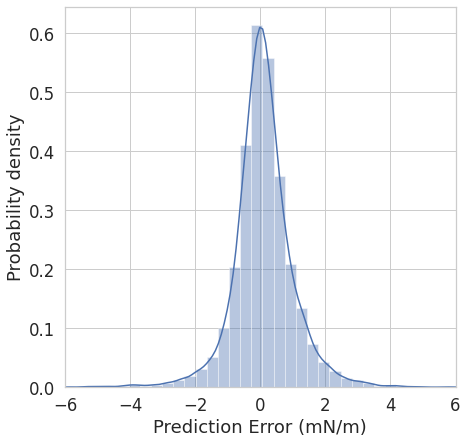

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


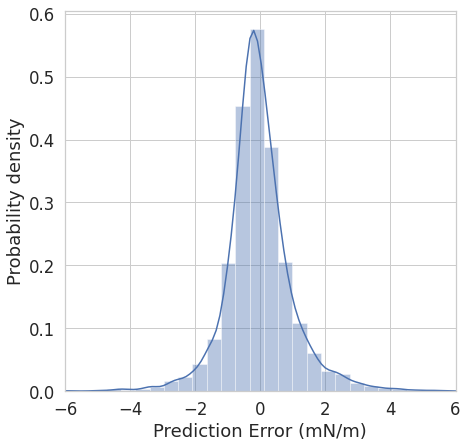

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


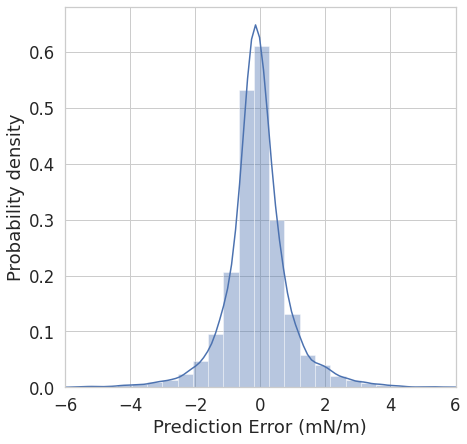

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


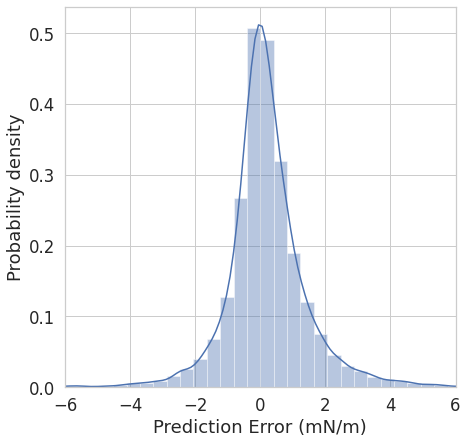

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


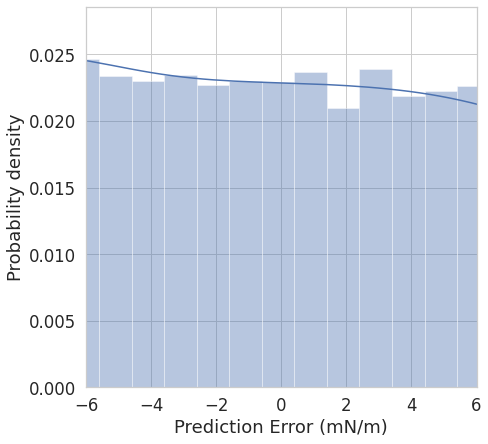

In [ ]:
noise_test_predictions={}
noise_train_predictions={}
noise_error_test={}
noise_error_train={}

sns.set_theme(style='whitegrid', font_scale=1.5)

for i in range(len(scale_list)):
  noise_test_predictions[i] = model_noisy[i].predict(normed_noisy_test_data[i]).flatten()
  noise_train_predictions[i] = model_noisy[i].predict(normed_noisy_train_data[i]).flatten()
  noise_error_test[i] = noise_test_predictions[i] - test_labels_noise[i]
  noise_error_train[i] = noise_train_predictions[i] - train_labels_noise[i]

  plt.figure(figsize=(7,7))
  sns.histplot(noise_error_test[i], bins = 50, kde=True, stat="density")
  plt.xlabel("Prediction Error (mN/m)")
  _ = plt.ylabel("Probability density")
  plt.xlim(-6, 6)
  plt.savefig('/content/drive/My Drive/DropLev/Dataset/In_Silico/error_distr_with_noise_%.1f' %scale_list[i], dpi=300, format='svg')
  plt.show()


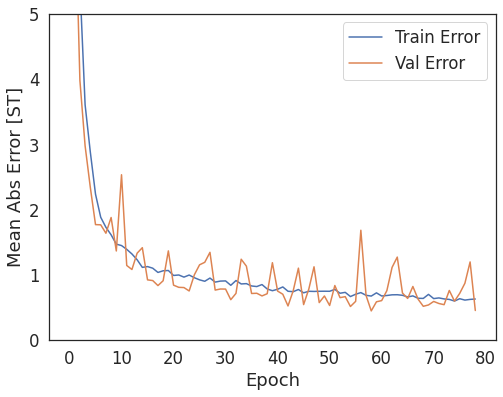

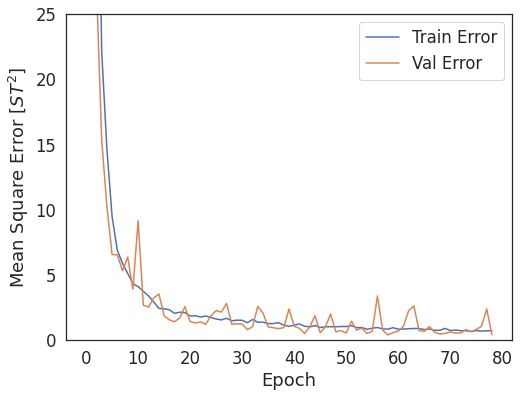

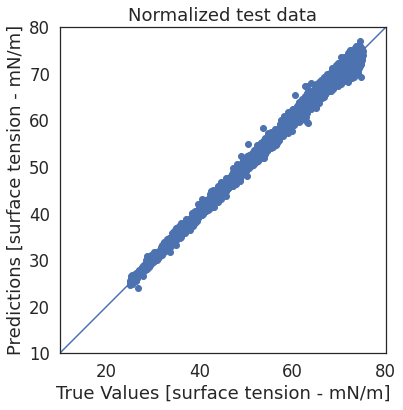

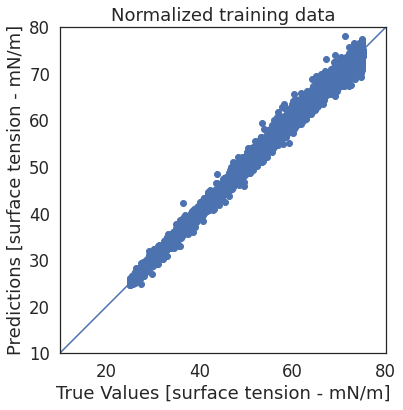

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


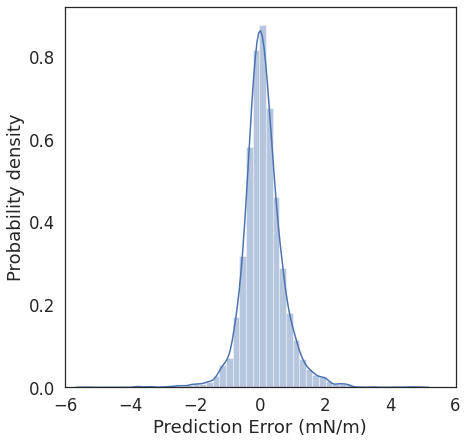

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


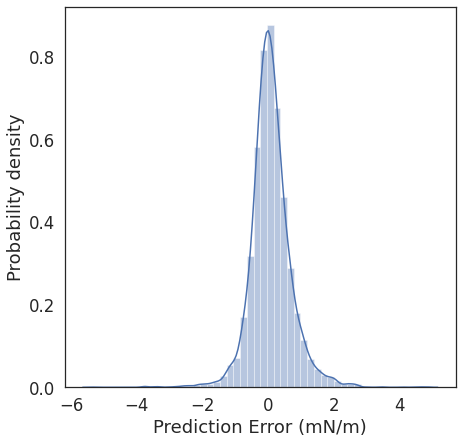

Text(0.5, 0, 'Surface tension (mN/m)')

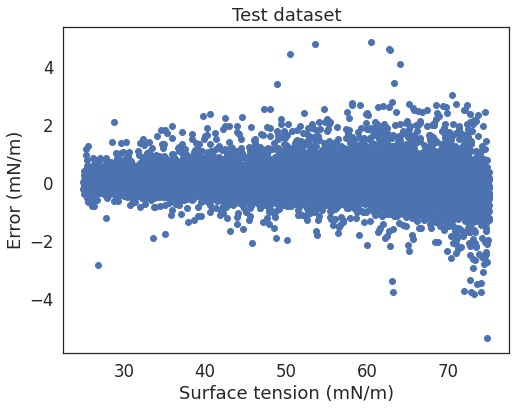

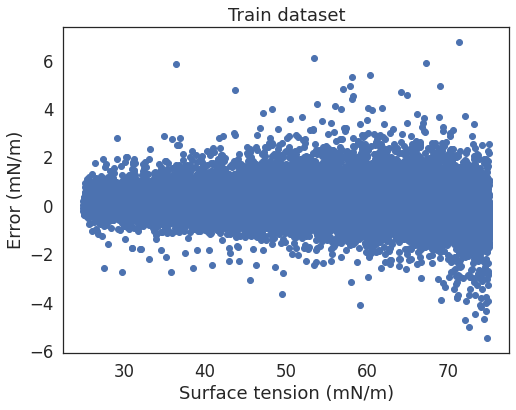

In [ ]:
# Data without noise
# Histrory
plot_history(history)

# Make predictions
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(8,6))
plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
# plt.savefig('Test_data_training', dpi=300, format='pdf')
plt.show()

train_predictions = model.predict(normed_train_data).flatten()

plt.figure(figsize=(8,6))
plt.scatter(train_labels, train_predictions)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


#Error distribution

error_test = test_predictions - test_labels

plt.figure(figsize=(7,7))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-6, 6)
# plt.savefig('error', dpi=300, format='pdf')
plt.show()

plt.figure(figsize=(7,7))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error (mN/m)")
_ = plt.ylabel("Probability density")
plt.show()
error_test = test_predictions - test_labels
error_train = train_predictions - train_labels

plt.figure(figsize=(8,6))
plt.title('Test dataset')
plt.plot(test_labels, error_test, 'o')
plt.ylabel('Error (mN/m)')
plt.xlabel('Surface tension (mN/m)')

plt.figure(figsize=(8,6))
plt.title('Train dataset')
plt.plot(train_labels, error_train, 'o')
plt.ylabel('Error (mN/m)')
plt.xlabel('Surface tension (mN/m)')


In [ ]:
# #Save prediction outcome in a csv file
# error_test = test_predictions - test_labels
# error_train = train_predictions - train_labels
# outcome_train=pd.DataFrame(data=np.array([train_labels.values, train_predictions]).T, columns=['Train_labels', 'Train_pred'])
# outcome_test=pd.DataFrame(data=np.array([test_labels.values, test_predictions]).T, columns=[ 'Test_labels', 'Test_pred'])

# date=str('20211019')

# model_No=3

# data_No=46685
# ST_min=25
# ST_max=75
# vol_min=0.5
# vol_max=2.5
# Ps_min=2000
# Ps_max=4000


# filename=str('data_%d_ST_%.2f_%.2f_vol_%.2f_%.2f_Ps_%d_%d_model_%d_%s.csv' %(data_No, ST_min, ST_max, vol_min, vol_max, Ps_min, Ps_max, model_No, date))
# !mkdir -p '/content/drive/My Drive/DropLev/Outcomes/' #Ceates a folder named "MachineLearningModels"
# outcome_train.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'train_out_'+filename, index=False)  #Saves the file
# outcome_test.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'test_out_'+filename, index=False)  #Saves the file

# hist.to_csv('/content/drive/My Drive/DropLev/Outcomes/'+'history_'+filename)


## Testing new data

In [77]:
dataset=pd.read_csv('/content/drive/MyDrive/DropLev/Dataset/In_Silico/insilico_dataset_after_conditions.csv')
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
46681,0.030986,0.043993,0.069600,0.076387,0.105062,0.146140,0.290678,0.299159,0.391326,0.464221,0.565064,0.569203,0.666356,0.679697,0.754009,0.764006,0.764584,0.787188,0.793261,0.804187,0.823263,0.836253,0.870887,0.887160,0.893436,0.914365,0.932719,0.950392,0.961020,0.995464,1.009505,1.052084,1.059491,1.088541,1.108529,1.111417,1.162814,1.206144,1.223849,1.356779,...,0.734074,0.724307,0.712627,0.708045,0.701435,0.689868,0.685407,0.684123,0.680043,0.668149,0.653693,0.634339,0.628660,0.617359,0.613480,0.611143,0.602544,0.593223,0.589916,0.587846,0.583124,0.581537,0.580342,0.572257,0.571020,0.570747,0.570433,0.569691,0.569239,0.564626,0.557214,0.556148,0.555720,0.554701,0.554566,1.339101,2752.622531,34.276755,0.741041,0.748316
46682,0.038777,0.123957,0.156229,0.218112,0.222731,0.278244,0.344845,0.345205,0.399409,0.408555,0.410336,0.440438,0.536236,0.538784,0.610972,0.649353,0.658938,0.678909,0.691060,0.805605,0.828973,0.868459,0.878488,0.887977,0.906155,0.911811,0.930759,0.943260,1.010227,1.023125,1.032232,1.065969,1.134421,1.144600,1.211254,1.302139,1.332799,1.365326,1.383467,1.420921,...,0.724426,0.722840,0.718034,0.716449,0.706849,0.704551,0.702575,0.687528,0.682838,0.678222,0.669438,0.665783,0.659099,0.652130,0.650087,0.646744,0.626694,0.616058,0.558982,0.557563,0.555575,0.553064,0.550219,0.545163,0.542331,0.533076,0.530391,0.528300,0.520418,0.518709,0.517191,0.511372,0.506265,0.504419,0.504152,1.214147,2727.981058,25.415084,0.680702,0.740520
46683,0.128272,0.154825,0.160611,0.185471,0.233474,0.234064,0.255616,0.260883,0.309816,0.311056,0.328478,0.337464,0.345611,0.383505,0.433317,0.450688,0.471809,0.489452,0.491457,0.518662,0.545618,0.557400,0.558547,0.566738,0.567763,0.567930,0.602699,0.658098,0.686073,0.722174,0.782130,0.789991,0.833004,0.845978,0.857322,0.880116,0.956044,0.985201,1.037332,1.106742,...,0.809784,0.805618,0.803567,0.796434,0.790950,0.786122,0.780197,0.771421,0.766052,0.763346,0.761428,0.759533,0.748139,0.744426,0.737012,0.736048,0.734195,0.734033,0.725834,0.723989,0.718744,0.711060,0.686122,0.684452,0.682860,0.673844,0.671814,0.670537,0.667521,0.667191,0.657454,0.653158,0.648567,0.648324,0.646719,1.804700,2597.176873,46.659271,0.797750,0.809736
46684,0.013660,0.036360,0.055418,0.061683,0.073678,0.073931,0.079744,0.081533,0.172635,0.179952,0.214857,0.267268,0.282536,0.431863,0.445217,0.528524,0.552429,0.597347,0.612681,0.719029,0.748883,0.759940,0.800368,0.863605,0.884327,0.922897,0.931120,0.996645,1.011853,1.051118,1.103788,1.158062,1.169598,1.174236,1.187968,1.242435,1.245514,1.266918,1.266935,1.282191,...,0.607423,0.607167,0.607165,0.605868,0.604892,0.604456,0.602452,0.595667,0.589031,0.588367,0.556469,0.553788,0.540557,0.520997,0.519582,0.519132,0.513790,0.507066,0.505845,0.491519,0.479792,0.475662,0.474676,0.474066,0.471497,0.469632,0.468571,0.466053,0.462696,0.459940,0.459474,0.458307,0.456212,0.454620,0.454418,0.720304,3246.519021,36.194150,0.746458,0.607396
46685,0.046605,0.056765,0.069487,0.103949,0.114617,0.150074,0.158009,0.193105,0.270087,0.296375,0.375794,0.420263,0.451831,0.462925,0.496030,0.527713,0.544195,0.591217,0.615911,0.653543,0.693551,0.755091,0.883826,0.988866,1.040353,1.044919,1.074094,1.198845,1.215064,1.217659,1.248714,1.391715,1.519090,1.526068,1.572406,1.630285,1.634155,1.634404,1.634902,1.642155,...,0.685097,0.684022,0.682567,0.682237,0.681

In [84]:
#Remove 10% of the data within a specific ST range

target=len(dataset)*0.1

ST_lim1=37
ST_lim2=30

trial=dataset.copy()

trial.drop(trial[(trial['ST'] > ST_lim1)].index, inplace=True)
trial.drop(trial[(trial['ST'] < ST_lim2)].index, inplace=True)
print((len(dataset)-len(trial))*100/len(dataset))

89.91346442188237 4668.6


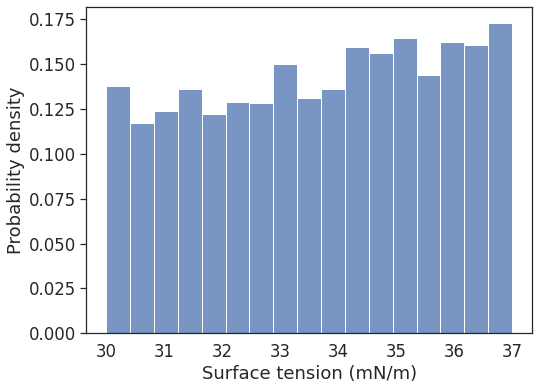

In [85]:
plt.figure(figsize=(8,6))
sns.histplot(trial.ST, kde=False, stat="density")
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Probability density')
plt.tick_params(bottom = False)

In [86]:
dataset=trial.copy()
dataset.reset_index(drop=True, inplace=True)
dataset

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST,AR,radius
0,0.018390,0.070453,0.241554,0.367267,0.472430,0.495262,0.540086,0.563635,0.592978,0.624496,0.631869,0.735346,0.761736,0.767978,0.801781,0.819314,0.845602,0.904731,0.945489,0.953636,0.987499,1.007197,1.074737,1.081028,1.087973,1.134097,1.166377,1.214199,1.259194,1.316490,1.326178,1.397697,1.415622,1.419542,1.505420,1.564812,1.643510,1.745301,1.752077,1.796733,...,0.709584,0.704998,0.704877,0.702198,0.698548,0.693512,0.690734,0.686218,0.676664,0.667193,0.665822,0.663568,0.662954,0.658536,0.655766,0.645613,0.639703,0.637653,0.636169,0.634261,0.625925,0.621900,0.611025,0.607310,0.601198,0.597725,0.584446,0.576343,0.575958,0.575217,0.573641,0.565261,0.560752,0.560434,0.559544,1.294405,2619.206780,33.413217,0.761708,0.734393
1,0.022041,0.075593,0.087488,0.101087,0.135662,0.186399,0.194859,0.258761,0.350516,0.411052,0.461075,0.464948,0.501280,0.518807,0.523795,0.553567,0.564530,0.572439,0.585171,0.592180,0.723248,0.755960,0.778340,0.839115,0.862264,0.949038,0.986992,1.000163,1.005385,1.038040,1.073359,1.105727,1.106948,1.134582,1.149566,1.207702,1.283804,1.378974,1.384091,1.389385,...,0.618613,0.618080,0.611691,0.593697,0.581008,0.574670,0.556407,0.555398,0.545777,0.532223,0.512660,0.509805,0.502978,0.498563,0.497433,0.497299,0.495085,0.489008,0.488830,0.484279,0.483040,0.480631,0.471141,0.464666,0.463063,0.462250,0.459243,0.447125,0.442143,0.440338,0.439257,0.438004,0.436249,0.435486,0.434134,0.787534,3539.019376,34.129512,0.675805,0.642127
2,0.056031,0.058364,0.102776,0.103351,0.105074,0.124741,0.145404,0.236549,0.239968,0.253712,0.373479,0.409880,0.428987,0.461754,0.512765,0.590793,0.593071,0.612229,0.671750,0.693052,0.701034,0.709992,0.758373,0.796262,0.871989,0.877338,0.899462,0.933515,0.967438,0.973334,1.033236,1.043266,1.089315,1.098893,1.175246,1.237283,1.245626,1.249970,1.273316,1.308882,...,0.827331,0.827318,0.819351,0.811820,0.798607,0.784573,0.768828,0.762729,0.761458,0.756558,0.745859,0.743532,0.735200,0.719364,0.714380,0.689779,0.670412,0.667523,0.665143,0.664702,0.657924,0.653882,0.652574,0.652473,0.646093,0.645676,0.639607,0.637324,0.637215,0.636725,0.627611,0.626222,0.624250,0.624067,0.624013,1.908522,2592.584982,36.567592,0.740948,0.842113
3,0.015517,0.015526,0.030288,0.056381,0.112602,0.117286,0.123093,0.125995,0.128862,0.279401,0.279623,0.295042,0.329923,0.345317,0.384359,0.418488,0.423851,0.460199,0.464100,0.539094,0.553190,0.562490,0.565536,0.567737,0.576705,0.649993,0.652552,0.775830,0.777597,0.815928,0.866615,0.887305,0.935501,0.965118,1.025576,1.060370,1.174066,1.210224,1.213093,1.272522,...,0.767560,0.767089,0.763333,0.762983,0.748392,0.742645,0.734065,0.731228,0.727338,0.724405,0.714375,0.703899,0.682771,0.678574,0.672786,0.669962,0.665786,0.654057,0.653062,0.644660,0.640075,0.638566,0.636389,0.633082,0.632955,0.628805,0.628303,0.625065,0.621936,0.621850,0.613828,0.600310,0.595441,0.594926,0.592504,1.615522,2654.723492,35.503575,0.744462,0.794970
4,0.107242,0.108267,0.122372,0.131830,0.144073,0.145474,0.182008,0.186700,0.193191,0.237380,0.265815,0.285088,0.306581,0.333894,0.352027,0.379464,0.428982,0.488718,0.490272,0.493671,0.504330,0.527771,0.547422,0.555722,0.708815,0.714358,0.752408,0.786742,0.809719,0.815404,0.829600,0.896956,0.957343,0.994505,1.025948,1.057526,1.074099,1.100145,1.183607,1.202590,...,0.556463,0.555411,0.553824,0.549159,0.547506,0.546925,0.54581

In [97]:
def prep_input(input):

  dataset.pop("Ar")
  dataset.pop('radius')
  
  return dataset



In [98]:
#Min-Max transformation

def MinMaxTransform(dataset, points):

  max_rho=[]
  min_rho=[]
  min_theta=[]
  max_theta=[]
  for i in range(len(dataset)):
    max_rho.append(max(dataset.iloc[i, points:2*points].values))
    min_rho.append(min(dataset.iloc[i, points:2*points].values))
    max_theta.append(max(dataset.iloc[i, 0:points].values))
    min_theta.append(min(dataset.iloc[i, 0:points].values))

  # print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = (OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset.iloc[i, points:2*points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  # Change the range of theta from 0 to 1

  OldMax= max(max_theta)
  OldMin=min(min_theta)

  NewValues_theta={}

  OldRange = (OldMax - OldMin)
  for i in range(len(dataset)):
    if (OldRange == 0):
        NewValue = NewMin
        NewValues.append(NewValue)
    else:
        NewValue = (dataset.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_theta[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T
  df_theta=pd.DataFrame.from_dict(NewValues_theta).T

  new_df=pd.concat([df_theta, df_rho], axis=1)

  return new_df


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


In [117]:
def cont_learn(normed_data, model, frac=0.5,random_state=0):
  # Display training progress by printing a single dot for each completed epoch
  class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
      if epoch % 100 == 0: print('')
      print('.', end='')
  
  if frac>0:
    #Split data into train and test
    normed_train_data = normed_data.sample(frac=frac,random_state=random_state)
    normed_test_data = normed_data.drop(normed_train_data.index)

    # Split features from labels
    train_labels = normed_train_data.pop('ST')
    test_labels = normed_test_data.pop('ST')


    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
    
    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

    test_predictions = model.predict(normed_test_data).flatten()

  elif frac==0:
    normed_test_data=normed_data
    test_labels = normed_data.pop('ST')
    test_predictions = model.predict(normed_test_data).flatten()
    mae=model.evaluate(normed_data, test_labels, verbose=0)
    history=None
  return test_predictions, test_labels, mae, history


In [100]:

def plot_history(history, savemode=False, path=None, filenameMAE=None, filenameMSE=None):

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  sns.set_theme(style='ticks', font_scale=1.5)
  
  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Abs Error of ST (mN/m)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename, dpi=300, format='svg')


  plt.figure(figsize=(8,6))
  plt.xlabel('Iteration (epoch)')
  plt.ylabel('Mean Square Error of ST (mN$^2$/m$^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2.5])
  plt.legend(frameon=False)
  if savemode==True:
    plt.savefig(path+filename, dpi=300, format='svg')
  plt.show()

In [128]:
from sklearn.utils import shuffle

#Define data
unseen_dataset=dataset.copy()

unseen_data=shuffle(unseen_data, random_state=0)

unseen_data.reset_index(drop=True, inplace=True)

# unseen_dataset=prep_input(unseen_data)

#Normalize data
points=175

stats = unseen_dataset.iloc[:, points*2:].describe()
stats = stats.transpose()

unseen_normed_rho_theta=MinMaxTransform(unseen_dataset, points)
unseen_normed_data_rest = min_max_norm(unseen_dataset.iloc[:, points*2:])

unseen_normed_data = unseen_normed_rho_theta.copy()
unseen_normed_data['vol'] = unseen_normed_data_rest.vol
unseen_normed_data['Ps'] = unseen_normed_data_rest.Ps

unseen_normed_data['ST'] = unseen_dataset.ST

unseen_normed_data.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.138,rho.139,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST
4704,0.002743,0.006277,0.008756,0.012530,0.012937,0.013173,0.015343,0.018336,0.027090,0.027402,0.030131,0.038236,0.053452,0.056462,0.070465,0.076554,0.077357,0.079174,0.085624,0.089156,0.089933,0.092986,0.095203,0.116817,0.127732,0.128777,0.130496,0.132971,0.146637,0.151168,0.152734,0.159144,0.163189,0.165933,0.166535,0.166666,0.170014,0.175637,0.179869,0.186970,...,0.897681,0.896131,0.892883,0.888424,0.888324,0.877080,0.867920,0.855086,0.853150,0.839083,0.830729,0.820223,0.785353,0.780344,0.765948,0.759887,0.741472,0.704963,0.633809,0.597753,0.588390,0.559973,0.553385,0.524480,0.514777,0.507613,0.484817,0.482355,0.480813,0.467531,0.437744,0.422734,0.413512,0.403910,0.403194,0.399177,0.396925,0.657156,0.455606,35.338761
4705,0.002826,0.011107,0.015849,0.016228,0.022441,0.034824,0.041250,0.044781,0.049445,0.060060,0.070553,0.071052,0.098999,0.099198,0.140889,0.142266,0.147096,0.158730,0.188172,0.192370,0.202935,0.206617,0.210727,0.212285,0.228774,0.235947,0.236848,0.242718,0.250952,0.258842,0.266291,0.268760,0.271413,0.279476,0.279594,0.284955,0.286143,0.293777,0.303805,0.322203,...,0.751014,0.743595,0.741127,0.740798,0.740660,0.731846,0.698263,0.696720,0.692164,0.687105,0.681802,0.665953,0.663902,0.655885,0.652085,0.635038,0.615781,0.610063,0.602404,0.586874,0.582687,0.579486,0.578212,0.567550,0.564099,0.560135,0.557614,0.556644,0.554742,0.550284,0.548538,0.547329,0.547145,0.546757,0.546411,0.546048,0.543666,0.588272,0.002305,35.002463
4706,0.004929,0.007000,0.011075,0.012155,0.016719,0.023257,0.046261,0.047611,0.062280,0.073881,0.089931,0.090590,0.106052,0.108175,0.120002,0.121593,0.121685,0.125283,0.126250,0.127988,0.131025,0.133092,0.138604,0.141194,0.142193,0.145524,0.148445,0.151258,0.152949,0.158431,0.160666,0.167443,0.168621,0.173245,0.176426,0.176886,0.185066,0.191962,0.194780,0.215936,...,0.753554,0.745690,0.744677,0.724579,0.700542,0.691114,0.677512,0.653711,0.644530,0.641887,0.633493,0.609018,0.579269,0.539443,0.527757,0.504504,0.496521,0.491712,0.474016,0.454836,0.448032,0.443772,0.434054,0.430789,0.428331,0.411693,0.409148,0.408587,0.407940,0.406413,0.405482,0.395991,0.380739,0.378545,0.377664,0.375566,0.375289,0.495624,0.378425,34.276755
4707,0.002172,0.005785,0.008818,0.009815,0.011724,0.011764,0.012690,0.012974,0.027474,0.028638,0.034193,0.042535,0.044965,0.068731,0.070857,0.084115,0.087920,0.095069,0.097509,0.114435,0.119187,0.120946,0.127381,0.137445,0.140743,0.146882,0.148191,0.158619,0.161040,0.167289,0.175672,0.184310,0.186146,0.186884,0.189069,0.197738,0.198228,0.201635,0.201637,0.204065,...,0.479903,0.482138,0.484056,0.483530,0.483526,0.480856,0.478848,0.477952,0.473827,0.459866,0.446211,0.444844,0.379204,0.373687,0.346462,0.306212,0.303300,0.302374,0.291381,0.277545,0.275032,0.245553,0.221421,0.212922,0.210894,0.209637,0.204352,0.200514,0.198331,0.193148,0.186241,0.180570,0.179611,0.177210,0.172899,0.169622,0.169206,0.129980,0.626962,36.194150
4708,0.007415,0.009032,0.011057,0.016542,0.018240,0.023883,0.025146,0.030732,0.042984,0.047167,0.059807,0.066885,0.071909,0.073675,0.078944,0.083986,0.086609,0.094093,0.098023,0.104013,0.110380,0.120175,0.140664,0.157381,0.165576,0.166302,0.170946,0.190800,0.193382,0.193795,0.198737,0.221497,0.241769,0.242880,0.250255,0.259466,0.260082,0.260122,0.260201,0.261356,...,0.653691,0.647369,0.643891,0.641680,0.638686,0.63800

In [124]:
#Import model
# folder=str('Latest_experimental_surfactants/')
# filename=str('Model_saved_1_20211027.h5')
# del model
model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/In_Silico/'+filename)

# Check its architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                14120     
                                                                 
 dense_1 (Dense)             (None, 25)                1025      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 15,281
Trainable params: 15,281
Non-trainable params: 0
_________________________________________________________________


In [125]:
#Make predictions
new_prediction, new_test_labels, new_mae, new_history =cont_learn(unseen_normed_data, model, frac=0, random_state=0)

error_test = new_prediction - new_test_labels


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
# hist = pd.DataFrame(new_history.history)
# hist['epoch'] = new_history.epoch
# hist.tail() 
plot_history(new_history)

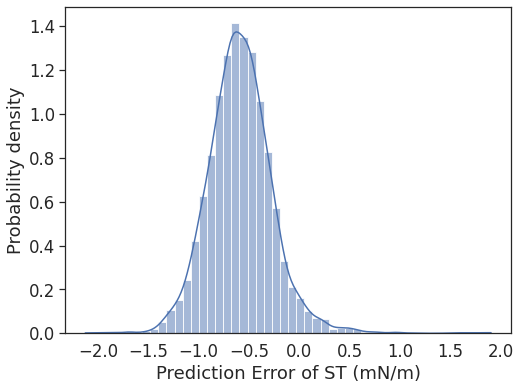

[0.6063864123266856, 0.6063866, 0.44861725]


In [126]:
sns.set_theme(style='ticks', font_scale=1.5)

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
# plt.xlim(-6, 6)
plt.tick_params(bottom = False)
# plt.savefig('/content/drive/My Drive/DropLev/Dataset/Experimental/test_data_error_distr_lim', dpi=300, format='svg')
plt.show()

print(new_mae)

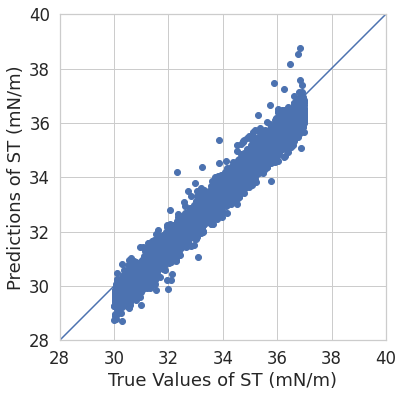

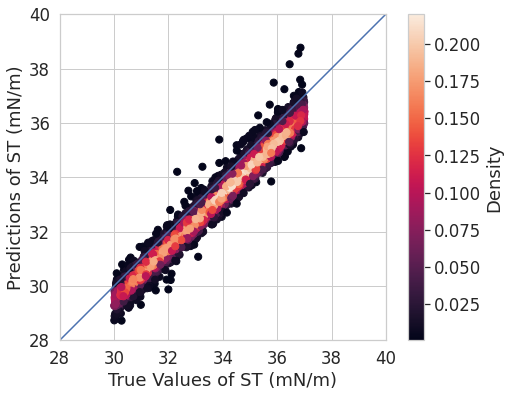

In [154]:
# labels = unseen_normed_data.pop('ST')
predictions = model.predict(unseen_normed_data).flatten()

sns.set_theme(style='whitegrid', font_scale=1.5)

plt.figure(figsize=(8,6))
plt.scatter(labels, predictions)
# plt.title('Normalized test data')
plt.xlabel('True Values of ST (mN/m)')
plt.ylabel('Predictions of ST (mN/m)')
plt.axis('equal')
plt.axis('square')
plt.xlim([28, 40])
plt.ylim([28, 40])
_ = plt.plot([-100, 100], [-100, 100])
# plt.savefig('/content/drive/My Drive/DropLev/Dataset/Experimental/test_data_error_plot', dpi=300, format='svg')
plt.show()

from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([labels, predictions])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,6))
im=ax.scatter(labels, predictions, c=z, s=50)
plt.xlabel('True Values of ST (mN/m)')
plt.ylabel('Predictions of ST (mN/m)')
plt.axis('equal')
plt.axis('square')
plt.xlim([28, 40])
plt.ylim([28, 40])
_ = plt.plot([-100, 100], [-100, 100])
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('Density')
plt.show()
